# Цель / задача работы

Задача - построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.

Чтобы соблюсти баланс, используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита.

# Описание признаков

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# Импорты библиотек

In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from numpy import linalg as LA
from sklearn.feature_selection import f_classif, mutual_info_classif
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralBiclustering

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

In [3]:
# !pip install shap

In [4]:
RANDOM_SEED = 5

# Импорт данных

In [5]:
df = pd.read_csv('train.csv')
df

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905  01FEB2014       SCH   M   62   Y        Y                0   
1          63161  12MAR2014       SCH   F   59   N        N                0   
2          25887  01FEB2014       SCH   M   25   Y        N                2   
3          16222  23JAN2014       SCH   F   53   N        N                0   
4         101655  18APR2014       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
73794      54887  04MAR2014       GRD   F   45   N        N                0   
73795      76821  24MAR2014       SCH   M   41   Y        Y                0   
73796     103695  22APR2014       SCH   M   31   N        N                0   
73797        861  04JAN2014       SCH   F   29   N        N                0   
73798      15796  23JAN2014       GRD   M   34   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0              0  -2.008753                1             50             1   
1              0  -1.532276                3             50             2   
2              0  -1.408142                1             80             1   
3              0  -2.057471                2             50             2   
4              1  -1.244723                1             60             2   
...          ...        ...              ...            ...           ...   
73794          0  -1.792064                3             50             1   
73795          0  -2.058029                1             50             2   
73796          0  -1.512635                4             80             2   
73797          1  -1.479334                3             50             1   
73798          0  -1.764711                2             50             2   

       work_address  income  sna  first_time foreign_passport  default  
0                 2   18000    4           1                N        0  
1                 3   19000    4           1                N        0  
2                 2   30000    1           4                Y        0  
3                 3   10000    1           3                N        0  
4                 3   30000    1           4                Y        0  
...             ...     ...  ...         ...              ...      ...  
73794             2   17000    4           4                N        0  
73795             2   70000    1           4                N        0  
73796             3   45000    2           2                N        0  
73797             3   13000    2           3                N        1  
73798             3   25000    1           3                N        0  

[73799 rows x 19 columns]

In [6]:
df.info()
# Датасет содержит 12 признаков в виде чисел int, 1 признак в виде float и 6 признаков в виде строк. 
# Пропуски содержит только признак education - non-null 73 492 строк из 73 799.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

## Обработка пропусков

In [7]:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

- SCH - school, школьное образование

- GRD - graduate, выпускник

- UGR - undergraduates, старшекурсники

- PGR - аспирант

- ACD - академик

In [8]:
df['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

In [9]:
print(f'Пустых значений: {df["education"].isna().sum()}, ' +
      f'это {100*df["education"].isna().sum() / len(df):0.2f}% от общего количества строк.')

Пустых значений: 307, это 0.42% от общего количества строк.


In [10]:
# Посмотрим, какое образование является модой
df["education"].mode()[0]

'SCH'

In [11]:
# Заполним пропуски значением, которое встречается чаще всего
df["education"].fillna('SCH', inplace=True)
# Теперь пропусков больше нет
df.isnull().sum() 

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64

In [12]:
# Дубликатов нет
df[df.duplicated(keep=False)]

Empty DataFrame
Columns: [client_id, app_date, education, sex, age, car, car_type, decline_app_cnt, good_work, score_bki, bki_request_cnt, region_rating, home_address, work_address, income, sna, first_time, foreign_passport, default]
Index: []

## Обработка числовых, бинарных и категор. признаков

In [13]:
# определим, какие признаки являются числовыми, какие - категориальные, и какие - бинарные
df.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

In [14]:
# Признаки с большим количеством уникальных значений отнесем к числовым, за исключением app_date,
# так как он содержит дату в виде строки. Данный признак необходимо преобразовать.
# Также не будем использовать признак client_id, так как все его значения уникальны и он никак не повлияет на модель.
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "region_rating", "income"]

# К бинарным отнесем остальные признаки, количество уникальных значений которых равно 2:
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] # 'default' - target

# Все остальные - категориальные:
cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

In [15]:
# Уникальные значения признака app_date
df["app_date"].unique()

array(['01FEB2014', '12MAR2014', '23JAN2014', '18APR2014', '18FEB2014',
       '04FEB2014', '17MAR2014', '14FEB2014', '10JAN2014', '03FEB2014',
       '08APR2014', '08JAN2014', '19MAR2014', '22JAN2014', '30JAN2014',
       '11MAR2014', '02FEB2014', '14APR2014', '06JAN2014', '24MAR2014',
       '15APR2014', '28FEB2014', '11FEB2014', '30MAR2014', '23MAR2014',
       '09MAR2014', '02MAR2014', '31JAN2014', '14MAR2014', '26JAN2014',
       '03APR2014', '22MAR2014', '11JAN2014', '17FEB2014', '13FEB2014',
       '17APR2014', '25FEB2014', '10APR2014', '01APR2014', '21APR2014',
       '20MAR2014', '03MAR2014', '25MAR2014', '24FEB2014', '16APR2014',
       '27FEB2014', '18MAR2014', '19FEB2014', '20FEB2014', '31MAR2014',
       '04MAR2014', '25JAN2014', '07JAN2014', '07MAR2014', '26MAR2014',
       '05FEB2014', '06MAR2014', '08FEB2014', '21JAN2014', '13MAR2014',
       '09JAN2014', '07FEB2014', '29JAN2014', '27JAN2014', '15FEB2014',
       '29APR2014', '04APR2014', '16JAN2014', '07APR2014', '13JA

In [16]:
# Данный признак в формате "ДДМММГГГГ"
# Извлекаем число, месяц и год из признака и преобразовываем его в формат datetime:
extracted_app_date_df = df["app_date"].str.extract("(\d{2})(\w{3})(\d{4})")
df["app_date"] = extracted_app_date_df.apply(lambda x: datetime.strptime(x[0]+x[1]+x[2], "%d%b%Y"),
                                             axis=1)

In [17]:
# Преобразовываем значение месяца в числовой формат и добавим новые признаки в наш датафрейм
extracted_app_date_df.columns = ["app_day", "app_month", "app_year"]
extracted_app_date_df["app_month"] = pd.to_datetime(extracted_app_date_df["app_month"],
                                                    format="%b").dt.month
extracted_app_date_df["app_day"] = extracted_app_date_df["app_day"].astype(int)
extracted_app_date_df["app_year"] = extracted_app_date_df["app_year"].astype(
    int)
df = pd.concat([df, extracted_app_date_df], axis=1)
df["app_weekday"] = df["app_date"].dt.weekday

df["app_year"].unique()

array([2014])

In [18]:
# В нашем датасете присутствуют только записи, где год подачи заявки - 2014
# Добавим новый признак, обозначающий количество дней прошедших с начала 2014 года
df["app_passed_days"] = (df["app_date"] - datetime(2014, 1, 1)).dt.days

# Распределим новые признаки к числовым переменным
num_cols.extend(["app_day", "app_month", "app_weekday", "app_passed_days"])

# Признак app_year не добавили, потому что это константа и он не поможет нам в предсказании целевой переменной. 
# app_date нам также не нужен, так как вся содержащаяся в нем информация уже есть в других признаках
df.drop(["app_date", "app_year"], axis=1, inplace=True)

# Обновленный датафрейм
df.head()

client_id education sex  age car car_type  decline_app_cnt  good_work  \
0      25905       SCH   M   62   Y        Y                0          0   
1      63161       SCH   F   59   N        N                0          0   
2      25887       SCH   M   25   Y        N                2          0   
3      16222       SCH   F   53   N        N                0          0   
4     101655       GRD   M   48   N        N                0          1   

   score_bki  bki_request_cnt  ...  work_address  income  sna  first_time  \
0  -2.008753                1  ...             2   18000    4           1   
1  -1.532276                3  ...             3   19000    4           1   
2  -1.408142                1  ...             2   30000    1           4   
3  -2.057471                2  ...             3   10000    1           3   
4  -1.244723                1  ...             3   30000    1           4   

   foreign_passport  default app_day  app_month  app_weekday  app_passed_days  
0                 N        0       1          2            5               31  
1                 N        0      12          3            2               70  
2                 Y        0       1          2            5               31  
3                 N        0      23          1            3               22  
4                 Y        0      18          4            4              107  

[5 rows x 22 columns]

In [19]:
# num_cols = 10
# num_cols = ["age", "decline_app_cnt", "score_bki",
#             "bki_request_cnt", "region_rating", "income", "app_day", "app_month", "app_weekday", "app_passed_days"]

# bin_cols = 5
# bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 

# cat_cols = 5
# cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

# client_id
# default - target

### Числовые

default
0     0.87
1     0.13

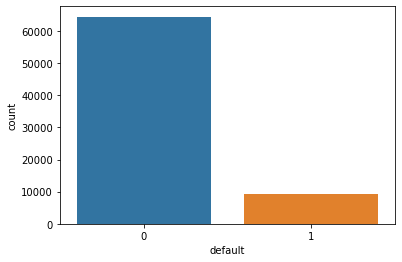

In [20]:
# Распределение целевой переменной
sns.countplot(x = df['default']);
#  Выборка несбалансированная
round(df['default'].value_counts(normalize=True), 2).to_frame()

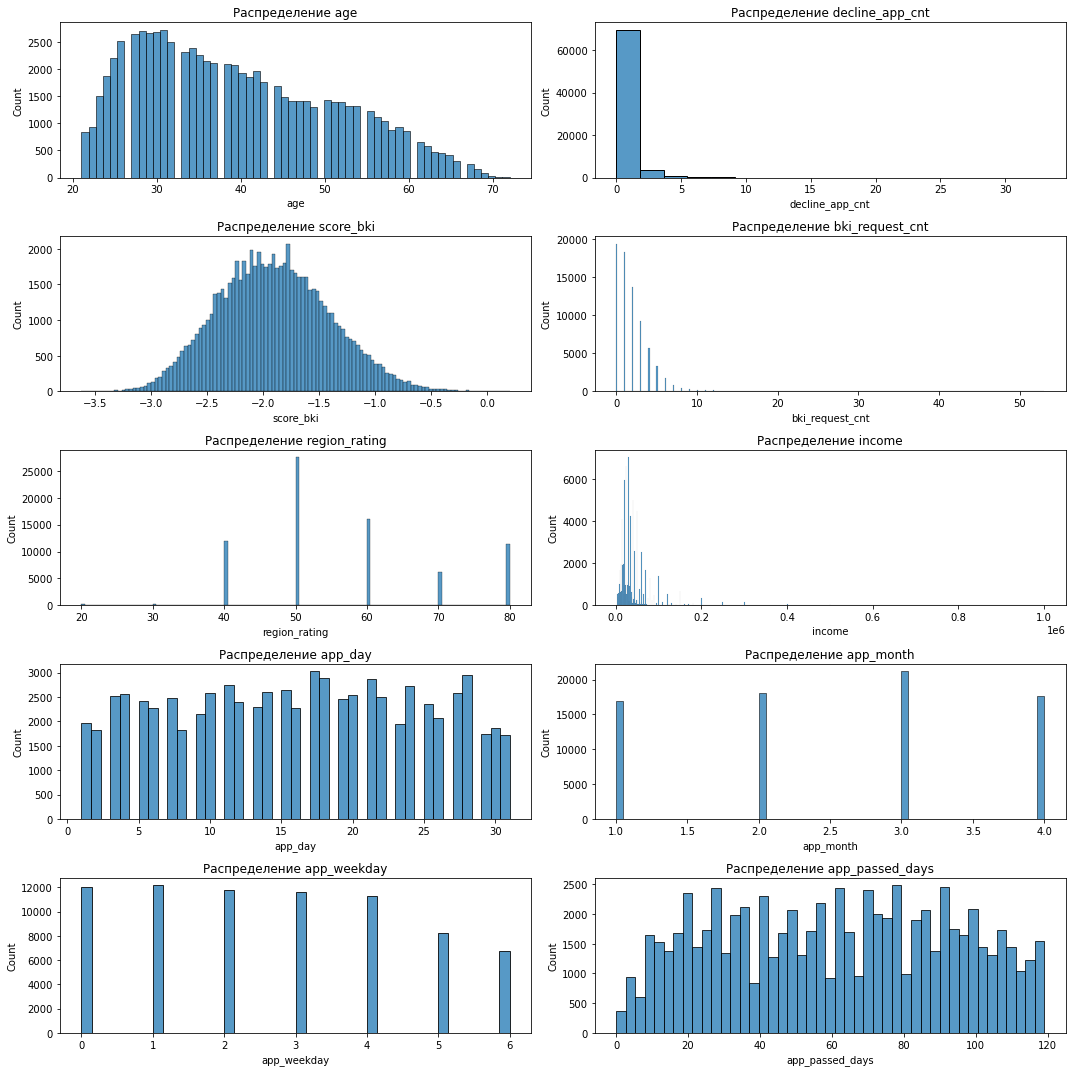

In [21]:
# Распределение числовых переменных:
plt.figure(figsize=[15, 15])
i = 1
for col in num_cols:
    plt.subplot(5, 2, i)
    plt.title(f"Распределение {col}")
    sns.histplot(df[col], kde=False)
    i += 1
plt.tight_layout()
plt.show()

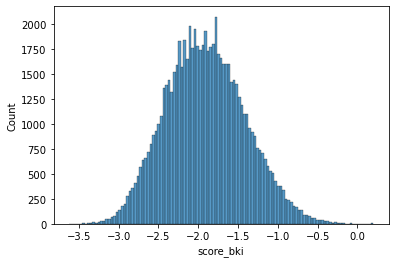

In [22]:
sns.histplot(x = df['score_bki']);

In [23]:
df[num_cols].describe()

age  decline_app_cnt     score_bki  bki_request_cnt  \
count  73799.000000     73799.000000  73799.000000     73799.000000   
mean      39.280641         0.275749     -1.904724         2.000339   
std       11.520378         0.804272      0.498231         2.252073   
min       21.000000         0.000000     -3.624586         0.000000   
25%       30.000000         0.000000     -2.259534         0.000000   
50%       37.000000         0.000000     -1.920823         1.000000   
75%       48.000000         0.000000     -1.569831         3.000000   
max       72.000000        33.000000      0.199773        53.000000   

       region_rating          income       app_day     app_month  \
count   73799.000000    73799.000000  73799.000000  73799.000000   
mean       56.725701    41099.775417     15.966517      2.537053   
std        13.055717    46166.322400      8.602978      1.089098   
min        20.000000     1000.000000      1.000000      1.000000   
25%        50.000000    20000.000000      9.000000      2.000000   
50%        50.000000    30000.000000     16.000000      3.000000   
75%        60.000000    48000.000000     23.000000      3.000000   
max        80.000000  1000000.000000     31.000000      4.000000   

        app_weekday  app_passed_days  
count  73799.000000     73799.000000  
mean       2.672231        61.035434  
std        1.897352        32.121884  
min        0.000000         0.000000  
25%        1.000000        33.000000  
50%        3.000000        62.000000  
75%        4.000000        89.000000  
max        6.000000       119.000000

#### Выводы по числовым признакам:
- *age*: график распределения возраста смещен влево, возраст имеет значения от 21 года до 72 лет и медианой 37 лет
- *decline_app_cnt* (количество отказанных прошлых заявок): распределение также смещено влево, большинству клиентов (более 75%) раньше не отказывали в кредите, есть небольшое количество клиентов, кому отказывали много раз, максимальный результат - 33 раза. Вполне возможно, что это не выброс и такая ситуация действительно возможна.
- *score_bki* (скоринговый балл): признак распределен нормально, однако, он имеет очень много отрицательных значений - это ошибка. См. диапазон скорингового балла ниже.
- *bki_request_cnt* (количество запросов в БКИ): распределение признака смещено влево, более 75% клиентов имеют значение менее 3 запросов (см. график), но есть те, у кого количество запросов достигает больших значений. Максимум - 53 запроса
- *region_rating*: рейтинг региона варьируется от 20 до 80
- *income*: доход клиентов варьируется от 1 000 до 1 000 000 с медианным показателем 30 000
- *app_day*, *app_month*, *app_weekday*: принимают значения от 1 до 31, от 1 до 4 и от 0 до 6 соответственно
- *app_passed_days* (количество дней с начала 2014 до даты подачи заявки): в датасете находятся данные только за первые 4 месяца 2014 года, количество заявок по дням похоже на равномерное распределение за исключением начала года. В начале года заявок несколько меньше - возможно из-за НГ праздников. Также можно отметить, что к концу месяца заявок также становится меньше - что позволяет наблюдать некую цикличность.

*Расчет кредитного рейтинга*
заемщика производится пока тремя самыми крупными БКИ, информация заемщикам передается двумя БКИ: НБКИ, ОКБ. Системы расчетов скорингового балла в разных БКИ различны, поэтому максимальный балл также различается в зависимости от компании. Например, в НБКИ – 850 баллов.

Расчет рейтинга заемщика может быть произведен по трем шкалам:
- 300–850;
- 0–999;
- 1–999.

![jupyter](./score.png)

#### Преобразование числовых признаков:

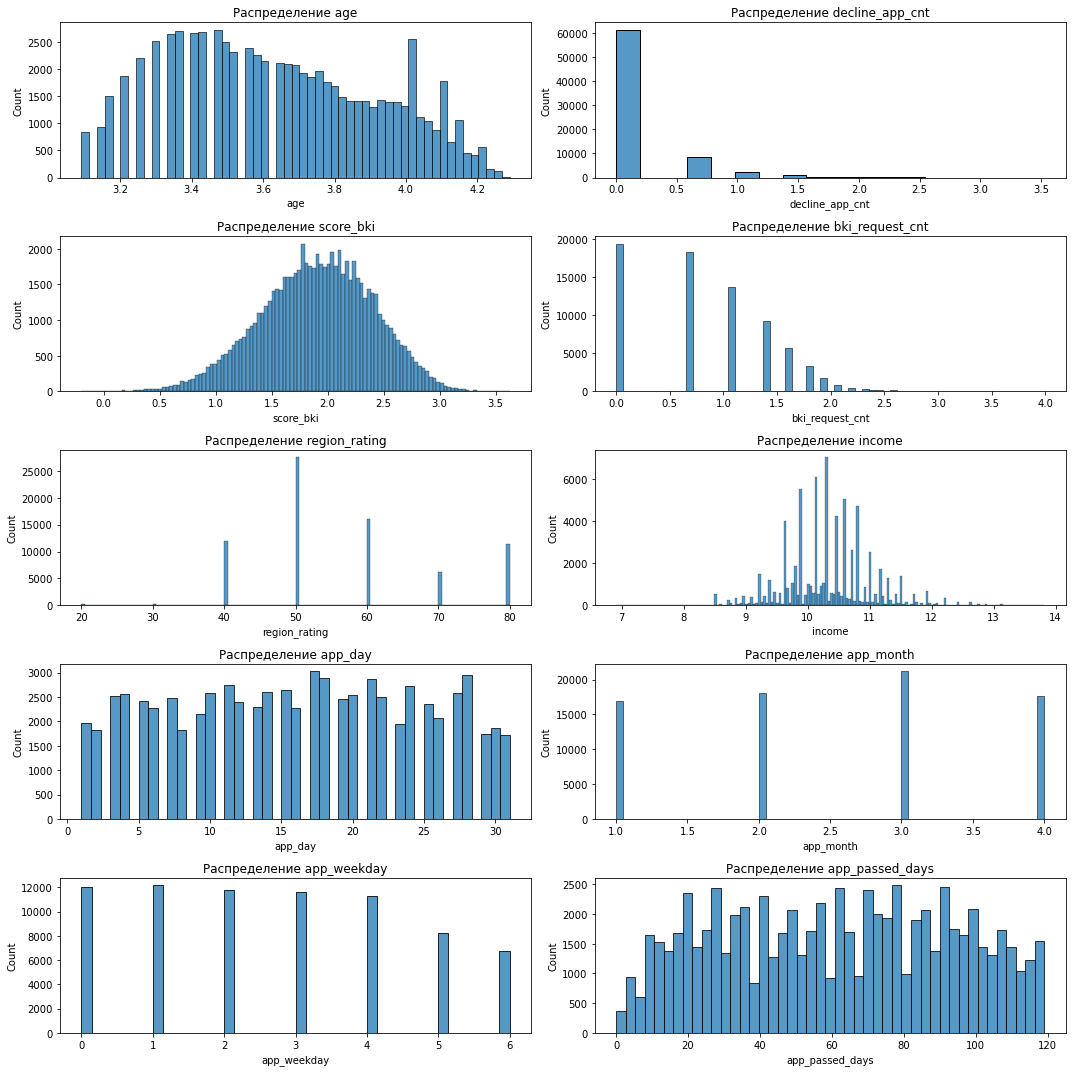

In [24]:
# Переводим значения скорингового балла в положительные значения (зеркальное отображение)
df["score_bki"] = -df["score_bki"]

# Признаки, которые имеют ярко выраженное смещение вправо - логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)
    
# Распределение числовых переменных после преобразования:
plt.figure(figsize=[15, 15])
i = 1
for col in num_cols:
    plt.subplot(5, 2, i)
    plt.title(f"Распределение {col}")
    sns.histplot(df[col], kde=False)
    i += 1
plt.tight_layout()
plt.show()

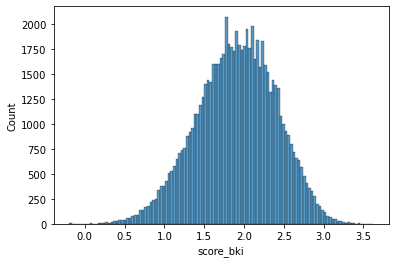

In [25]:
sns.histplot(x = df['score_bki']);

### Бинарные

In [26]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [27]:
bins = df[bin_cols]
print('Уникальные значения каждого категориального признака:')
for col in bins:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
sex :  ['M' 'F']
car :  ['Y' 'N']
car_type :  ['Y' 'N']
good_work :  [0 1]
foreign_passport :  ['N' 'Y']


In [28]:
# Распределение бинарных признаков
for col in bins:
    print(round(df[col].value_counts(normalize=True), 2).to_frame())
    print()

    sex
F  0.56
M  0.44

    car
N  0.68
Y  0.32

   car_type
N      0.81
Y      0.19

   good_work
0       0.84
1       0.16

   foreign_passport
N              0.85
Y              0.15



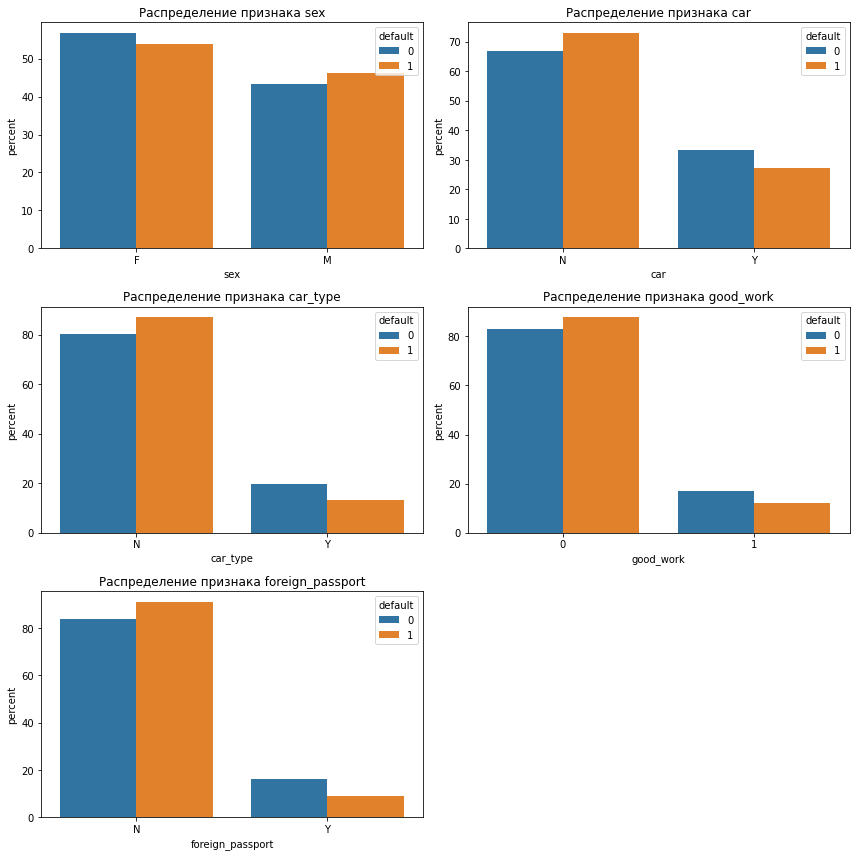

In [29]:
# Распределение показателя дефолта по бинарному признаку:

plt.figure(figsize=(12, 12))
k=1
for col in bins:
    plt.subplot(3, 2, k)
    prop_df = df[col].groupby(df["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")
    k += 1
plt.tight_layout()
plt.show()

#### Выводы по бинарным признакам:
- Женщин и мужчин примерно одинаково. Женщины менее склонны к дефолту, чем мужчины.
- Клиентов с машиной примерно в 2 раза меньше, чем без машины. Те, у кого есть машина, а также если это иномарка - более кредитоспособны. 
- Наличие 'хорошей работы' и загран. паспорта увеличивает шансы в выдаче кредита, однако таких клиентов мало.

#### Преобразование бинарных признаков:

In [30]:
# Кодируем бинарные признаки

mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

mapp

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

In [31]:
print('Уникальные значения каждого категориального признака:')
for col in bins:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
sex :  [1 0]
car :  [1 0]
car_type :  [1 0]
good_work :  [0 1]
foreign_passport :  [0 1]


In [32]:
df.head(3)

client_id education  sex       age  car  car_type  decline_app_cnt  \
0      25905       SCH    1  4.143135    1         1         0.000000   
1      63161       SCH    0  4.094345    0         0         0.000000   
2      25887       SCH    1  3.258097    1         0         1.098612   

   good_work  score_bki  bki_request_cnt  ...  work_address     income  sna  \
0          0   2.008753         0.693147  ...             2   9.798183    4   
1          0   1.532276         1.386294  ...             3   9.852247    4   
2          0   1.408142         0.693147  ...             2  10.308986    1   

   first_time  foreign_passport  default  app_day  app_month  app_weekday  \
0           1                 0        0        1          2            5   
1           1                 0        0       12          3            2   
2           4                 1        0        1          2            5   

   app_passed_days  
0               31  
1               70  
2               31  

[3 rows x 22 columns]

### Категориальные

In [33]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time']

- education - уровень образования
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике

In [34]:
categ = df[cat_cols]
print('Уникальные значения каждого категориального признака:')
for col in categ:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
education :  ['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
home_address :  [1 2 3]
work_address :  [2 3 1]
sna :  [4 1 2 3]
first_time :  [1 4 3 2]


In [35]:
# Распределение бинарных признаков
for col in categ:
    print(round(df[col].value_counts(normalize=True), 2).to_frame())
    print()

     education
SCH       0.53
GRD       0.32
UGR       0.13
PGR       0.02
ACD       0.00

   home_address
2          0.54
1          0.44
3          0.02

   work_address
3          0.61
2          0.28
1          0.11

    sna
1  0.64
4  0.16
2  0.14
3  0.06

   first_time
3        0.42
4        0.25
1        0.17
2        0.16



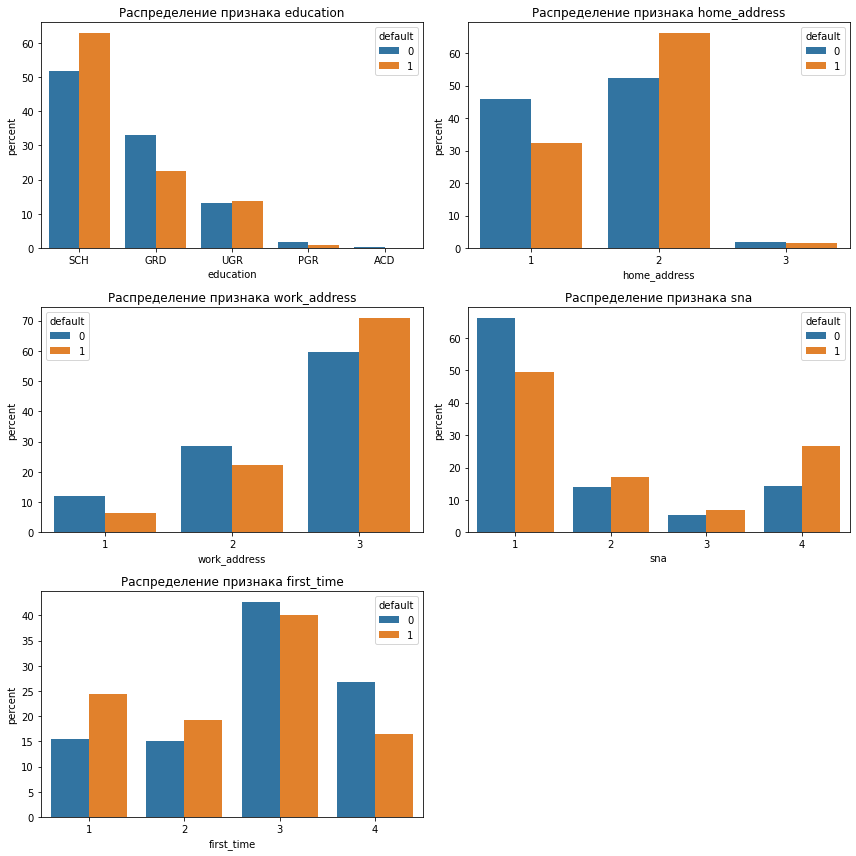

In [36]:
# Распределение показателя дефолта по бинарному признаку:

plt.figure(figsize=(12, 12))
k=1
for col in categ:
    plt.subplot(3, 2, k)
    prop_df = df[col].groupby(df["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")
    k += 1
plt.tight_layout()
plt.show()

#### Выводы по категориальным признакам:

- *education*: чем выше уровень образования у клиента, тем выше вероятность вернуть кредит. Данный признак является ординальным признаком, поэтому можно перекодировать его значения так, чтобы значения возрастали при увеличении уровня образования, от 0 - школа, до 4 - академик.
- *home_address*: домашние адреса распределены по 3 категориям. Клиенты, проживающие в 1 категории адреса более кредитоспособны, чем во второй и в третьей. Можно предположить, что группировка идет от домов премиум класса к эконом.
- *work_address*: рабочие адреса также распределены по 3 категориям. Клиенты, работающие в 1 и 2 категориях адреса более кредитоспособны, чем работающие в 3 категории - возможно это классификация категории офиса (класс А, В, С)
- *sna* (связь заемщика с клиентами банка): чем выше показатель, тем выше риск невозврата кредита по отношению к общему числу кредитов этого класса
- *first_time* (давность наличия информациии о заемщике): чем выше показатель (3 и 4 категория), тем более благонадежен клиент

#### Преобразование категориальных признаков:

In [37]:
df["education"].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [38]:
# Перекодирование признака "education", от 0 - школа, до 4 - академик:
categories = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[categories]).fit_transform(
    df[["education"]])[:, 0].astype(int)

In [39]:
df.head()

client_id  education  sex       age  car  car_type  decline_app_cnt  \
0      25905          0    1  4.143135    1         1         0.000000   
1      63161          0    0  4.094345    0         0         0.000000   
2      25887          0    1  3.258097    1         0         1.098612   
3      16222          0    0  3.988984    0         0         0.000000   
4     101655          2    1  3.891820    0         0         0.000000   

   good_work  score_bki  bki_request_cnt  ...  work_address     income  sna  \
0          0   2.008753         0.693147  ...             2   9.798183    4   
1          0   1.532276         1.386294  ...             3   9.852247    4   
2          0   1.408142         0.693147  ...             2  10.308986    1   
3          0   2.057471         1.098612  ...             3   9.210440    1   
4          1   1.244723         0.693147  ...             3  10.308986    1   

   first_time  foreign_passport  default  app_day  app_month  app_weekday  \
0           1                 0        0        1          2            5   
1           1                 0        0       12          3            2   
2           4                 1        0        1          2            5   
3           3                 0        0       23          1            3   
4           4                 1        0       18          4            4   

   app_passed_days  
0               31  
1               70  
2               31  
3               22  
4              107  

[5 rows x 22 columns]

#### Корреляционный анализ

In [40]:
# Удаление столбца с номером клиента

df.drop('client_id', axis=1, inplace=True)
df.head(3)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
0          0    1  4.143135    1         1         0.000000          0   
1          0    0  4.094345    0         0         0.000000          0   
2          0    1  3.258097    1         0         1.098612          0   

   score_bki  bki_request_cnt  region_rating  ...  work_address     income  \
0   2.008753         0.693147             50  ...             2   9.798183   
1   1.532276         1.386294             50  ...             3   9.852247   
2   1.408142         0.693147             80  ...             2  10.308986   

   sna  first_time  foreign_passport  default  app_day  app_month  \
0    4           1                 0        0        1          2   
1    4           1                 0        0       12          3   
2    1           4                 1        0        1          2   

   app_weekday  app_passed_days  
0            5               31  
1            2               70  
2            5               31  

[3 rows x 21 columns]

<AxesSubplot:title={'center':'Correlation Matrix of dataset features'}>

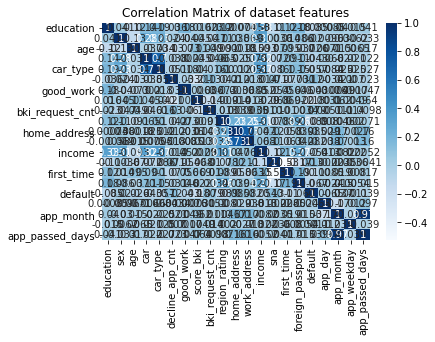

In [41]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(df.corr(), annot = True, cmap='Blues')

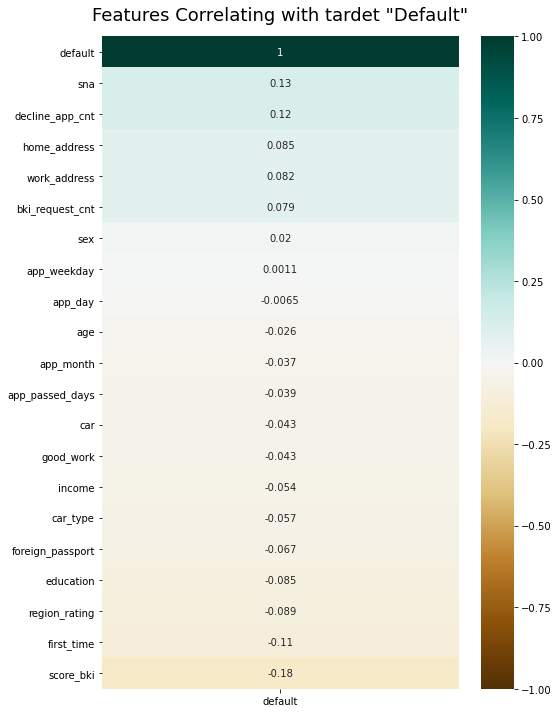

In [42]:
# Корреляция каждого признака с таргетом по убываюнию

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['default']].sort_values(by='default', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with tardet "Default"', fontdict={'fontsize':18}, pad=16);

In [43]:
# Определение ранга матрицы:

matrix = df.values # переавожу данные в матрицу, взяв значения признаков
# для визуального удобства перевожу в матрицу в таблицу
dataset=pd.DataFrame(data=matrix[0:,0:],
                     index=[i for i in range(matrix.shape[0])],
                     columns=['f'+str(i) for i in range(matrix.shape[1])])
dataset.head()

f0   f1        f2   f3   f4        f5   f6        f7        f8    f9  ...  \
0  0.0  1.0  4.143135  1.0  1.0  0.000000  0.0  2.008753  0.693147  50.0  ...   
1  0.0  0.0  4.094345  0.0  0.0  0.000000  0.0  1.532276  1.386294  50.0  ...   
2  0.0  1.0  3.258097  1.0  0.0  1.098612  0.0  1.408142  0.693147  80.0  ...   
3  0.0  0.0  3.988984  0.0  0.0  0.000000  0.0  2.057471  1.098612  50.0  ...   
4  2.0  1.0  3.891820  0.0  0.0  0.000000  1.0  1.244723  0.693147  60.0  ...   

   f11        f12  f13  f14  f15  f16   f17  f18  f19    f20  
0  2.0   9.798183  4.0  1.0  0.0  0.0   1.0  2.0  5.0   31.0  
1  3.0   9.852247  4.0  1.0  0.0  0.0  12.0  3.0  2.0   70.0  
2  2.0  10.308986  1.0  4.0  1.0  0.0   1.0  2.0  5.0   31.0  
3  3.0   9.210440  1.0  3.0  0.0  0.0  23.0  1.0  3.0   22.0  
4  3.0  10.308986  1.0  4.0  1.0  0.0  18.0  4.0  4.0  107.0  

[5 rows x 21 columns]

In [44]:
# Определение ранга матрицы признаков, расчет:

rank = LA.matrix_rank(dataset)
colms = len(df.columns)
print('Matrix rank =', rank)
print('Nums of columns =', colms)

Matrix rank = 21
Nums of columns = 21


#### Значимость признаков

Дисперсионный  анализ ANOVA (analysis of variance) используется для проверки влияния переменных друг на друга. 
Данный метод направлен на поиск зависимостей в данных путём исследования значимости различий в средних значениях. В отличие от t-критерия, позволяет сравнивать средние значения трёх и более групп. Разработан Р. Фишером для анализа результатов экспериментальных исследований.

<AxesSubplot:>

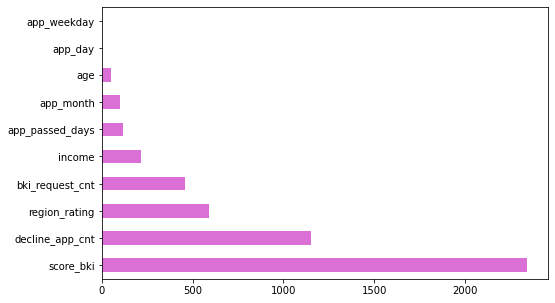

In [45]:
# Анализ ANOVA для определения значимости числовых признаков:

imp_num = pd.Series(f_classif(df[num_cols], df["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(8, 5))
imp_num.plot(kind="barh", facecolor='orchid')

<AxesSubplot:>

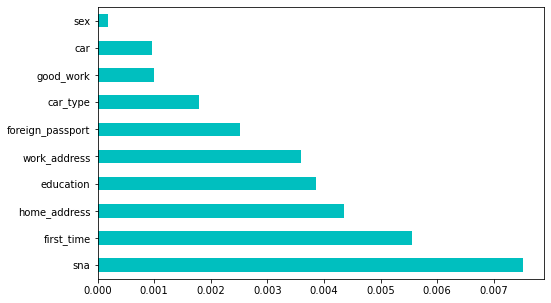

In [46]:
# определим значимость категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df["default"],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(8, 5))
imp_cat.plot(kind="barh", facecolor='c') 

In [47]:
# Статистическая гипотеза хи-квадрат Пирсона - это проверка независимости категориальных переменных.

# Нулевая гипотеза ( H0 ) утверждает, что нет никакой связи между переменными. 
# Альтернативная гипотеза могла бы утверждать, что между ними существует значительная связь .

# Используя p-значение :
# Мы определяем фактор значимости, чтобы определить, имеет ли отношение между переменными значимость. 
# Обычно выбирается коэффициент значимости или значение альфа 0,05. 
# Альфа-значение обозначает вероятность ошибочного отклонения H0, когда оно истинно. 
# Если значение p для теста оказывается строго больше, чем значение альфа, то H0 остается верным.

from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(df[cat_cols])
alpha = 0.05 # определение p-value
print ( "p = " + str (p))
if p <= alpha:
    print ( 'Зависимы (Нулевая гипотеза (H0) отвергается' )
else :
    print ( 'Независимы, нулевая гипотеза (H0) не отвергается' )

p = 1.0
Независимы, нулевая гипотеза (H0) не отвергается


#### Выводы по Корреляции и Значимости

- Существенная корреляция между домашним адресом и местом работы (0.73).
- Сильная корреляция между car, car_type (0.7). Отсутствие автомобиля и соответственное отсутствие признака, что автомобиль иностранный. Можно попробовать соединить два признака в один, получив новый категориальный признак. Так можно уменьшить размерность набора данных, но не потерять информацию.
- Есть довольно сильная обратная зависимость между sna, first_time. 

- Менее значимые признаки: app_day и app_weekday
- Наиболее статистически значимые категориальные признаки - sna и first_time.
- Наиболее статистически значимые числовые признаки - Score_bki, decline_app_cnt. Мультиколлинеарность в целом отсутствует, что подтверждается рангом матрицы. 

--- ***Рангом называют максимальное число линейно независимых строк (столбцов) матрицы.*** Линейная независимость означает, что строки (столбцы) не могут быть линейно выражены через другие строки (столбцы).


#### Get_dummies

In [48]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time']

In [49]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1  4.143135    1         1         0.000000          0   2.008753   
1    0  4.094345    0         0         0.000000          0   1.532276   
2    1  3.258097    1         0         1.098612          0   1.408142   
3    0  3.988984    0         0         0.000000          0   2.057471   
4    1  3.891820    0         0         0.000000          1   1.244723   

   bki_request_cnt  region_rating     income  ...  home_address_2  \
0         0.693147             50   9.798183  ...               0   
1         1.386294             50   9.852247  ...               1   
2         0.693147             80  10.308986  ...               0   
3         1.098612             50   9.210440  ...               1   
4         0.693147             60  10.308986  ...               1   

   home_address_3  work_address_2  work_address_3  sna_2  sna_3  sna_4  \
0               0               1               0      0      0      1   
1               0               0               1      0      0      1   
2               0               1               0      0      0      0   
3               0               0               1      0      0      0   
4               0               0               1      0      0      0   

   first_time_2  first_time_3  first_time_4  
0             0             0             0  
1             0             0             0  
2             0             0             1  
3             0             1             0  
4             0             0             1  

[5 rows x 30 columns]

#### Кодирование цикличных признаков (время)

In [50]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_day', 'app_month', 'app_weekday',
       'app_passed_days', 'education_1', 'education_2', 'education_3',
       'education_4', 'home_address_2', 'home_address_3', 'work_address_2',
       'work_address_3', 'sna_2', 'sna_3', 'sna_4', 'first_time_2',
       'first_time_3', 'first_time_4'],
      dtype='object')

In [51]:
print("app_month, unique:", df['app_month'].unique())
print("app_weekday, unique:", df['app_weekday'].unique())
print("app_day, unique:", df['app_day'].unique())

app_month, unique: [2 3 1 4]
app_weekday, unique: [5 2 3 4 1 0 6]
app_day, unique: [ 1 12 23 18  4 17 14 10  3  8 19 22 30 11  2  6 24 15 28  9 31 26 13 25
 21 20 16 27  7  5 29]


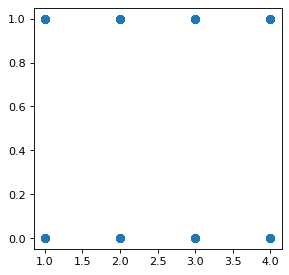

In [52]:
x = df['app_month']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

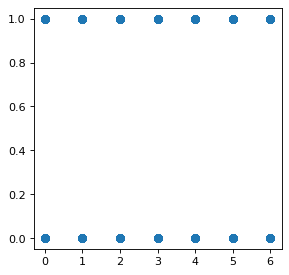

In [53]:
x = df['app_weekday']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

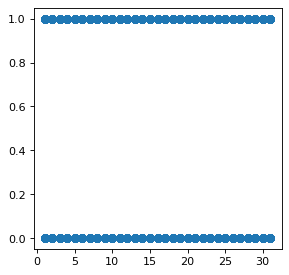

In [54]:
x = df['app_day']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

In [55]:
# Т.к. признаки 'app_day', 'app_month', 'app_weekday' относятся ко времени - они цикличны
# Не смотря на то, что в данном датасете присутствуют только первые 4 месяца (а не 12) - их нельзя сравнивать в числовом виде.
# Например апрель (= 4) не может быть численно больше января (= 1)
# Вышеуказанные признаки необходимо закодировать через синус или косинус (это масштабирует данные, сохраняя цикличность):

month =  12
weekday = 7
days = 31

# Нормализация x от 0 до 2π, что соответствует одному косинусному циклу

df["month_norm"] = 2 * math.pi * df["app_month"] / df["app_month"].max()
df["weekday_norm"] = 2 * math.pi * df["app_weekday"] / df["app_weekday"].max()
df["day_norm"] = 2 * math.pi * df["app_day"] / df["app_day"].max()

# Кодирование

df["sin_month"] = np.sin(df["month_norm"])
df["cos_month"] = np.cos(df["month_norm"])

df["sin_weekday"] = np.sin(df["weekday_norm"])
df["cos_weekday"] = np.cos(df["weekday_norm"])

df["sin_day"] = np.sin(df["day_norm"])
df["cos_day"] = np.cos(df["day_norm"])


df[['sin_month', 'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day']].head(5)

sin_month     cos_month   sin_weekday  cos_weekday   sin_day   cos_day
0  1.224647e-16 -1.000000e+00 -8.660254e-01          0.5  0.201299  0.979530
1 -1.000000e+00 -1.836970e-16  8.660254e-01         -0.5  0.651372 -0.758758
2  1.224647e-16 -1.000000e+00 -8.660254e-01          0.5  0.201299  0.979530
3  1.000000e+00  6.123234e-17  1.224647e-16         -1.0 -0.998717 -0.050649
4 -2.449294e-16  1.000000e+00 -8.660254e-01         -0.5 -0.485302 -0.874347

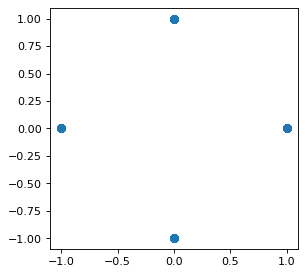

In [56]:
x = df['sin_month']
y = df['cos_month']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

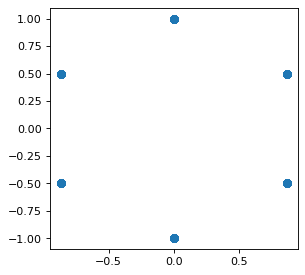

In [57]:
x = df['sin_weekday']
y = df['cos_weekday']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

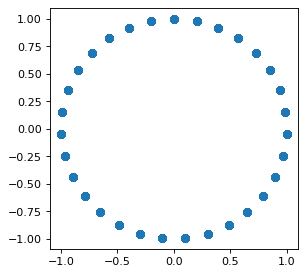

In [58]:
x = df['sin_day']
y = df['cos_day']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

In [59]:
# Проверка на 25-ти рандомных значениях из датасета:

import plotly.graph_objects as go

df_selected = df[["sin_day","cos_day"]].sample(25).sort_index()
display(df_selected)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_selected.cos_day, y=df_selected.sin_day, mode="markers"))

fig.update_layout(xaxis = dict(title="cos_day"),
                  yaxis = dict(title="sin_day", scaleanchor = "x", scaleratio = 1))

fig.show()

sin_day   cos_day
23    -5.712682e-01  0.820763
1468   4.853020e-01 -0.874347
2692  -5.712682e-01  0.820763
6363  -8.978045e-01 -0.440394
9039   9.377521e-01  0.347305
10628 -6.513725e-01 -0.758758
19077  9.680771e-01 -0.250653
22570 -8.486443e-01  0.528964
24264 -2.449294e-16  1.000000
32255 -7.907757e-01 -0.612106
32742 -7.907757e-01 -0.612106
32764 -7.247928e-01  0.688967
34586  9.680771e-01 -0.250653
35063  3.943559e-01  0.918958
36317  8.978045e-01 -0.440394
47355 -9.377521e-01  0.347305
48018  6.513725e-01 -0.758758
48554 -8.978045e-01 -0.440394
49446 -2.449294e-16  1.000000
51379  3.943559e-01  0.918958
52146  9.680771e-01 -0.250653
55977 -3.943559e-01  0.918958
58555 -6.513725e-01 -0.758758
63792  9.987165e-01 -0.050649
73633  7.247928e-01  0.688967

In [60]:
df.columns
# нужно удалить лишние признаки - 'app_day', 'app_month', 'app_weekday', 'month_norm', 'weekday_norm', 'day_norm'

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_day', 'app_month', 'app_weekday',
       'app_passed_days', 'education_1', 'education_2', 'education_3',
       'education_4', 'home_address_2', 'home_address_3', 'work_address_2',
       'work_address_3', 'sna_2', 'sna_3', 'sna_4', 'first_time_2',
       'first_time_3', 'first_time_4', 'month_norm', 'weekday_norm',
       'day_norm', 'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday',
       'sin_day', 'cos_day'],
      dtype='object')

In [61]:
df.drop(['app_day', 'app_month', 'app_weekday', 'month_norm', 'weekday_norm', 'day_norm'], axis=1, inplace=True)
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

#### Масштабирование данных (нормализация)

In [62]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

In [63]:
# num_cols = 7
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "region_rating", "income", "app_passed_days"]

# bin_cols = 5
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 

# cat_cols = 14
cat_cols = ['education_1', 'education_2', 'education_3', 'education_4', 
            'home_address_2','home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
            'sna_4', 'first_time_2', 'first_time_3', 'first_time_4']

# other = 6
# other = 'sin_month','cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'
# default - target

- Нормализация подразумевает изменение диапазонов в данных без изменения формы распределения
- Стандартизация изменяет форму распределения данных (приводится к нормальному распределению)

Поскольку выше было применено логарифмирование, на данном этапе Стандартизация не требуется.
Возможно Нормализация числовых признаков поможет добиться лучшего качества модели.

Алгоритмы машинного обучения работают лучше, когда различные функции (переменные) имеют меньший масштаб. 
Нормализация делает процесс обучения менее чувствительным к масштабу функций. Это приводит к улучшению коэффициентов после тренировки.

![jupyter](./Screenshot_4.png)

![jupyter](./Screenshot_1.png)

In [64]:
df[num_cols].head()

age  decline_app_cnt  score_bki  bki_request_cnt  region_rating  \
0  4.143135         0.000000   2.008753         0.693147             50   
1  4.094345         0.000000   1.532276         1.386294             50   
2  3.258097         1.098612   1.408142         0.693147             80   
3  3.988984         0.000000   2.057471         1.098612             50   
4  3.891820         0.000000   1.244723         0.693147             60   

      income  app_passed_days  
0   9.798183               31  
1   9.852247               70  
2  10.308986               31  
3   9.210440               22  
4  10.308986              107

In [65]:
# Нормализация числовых признаков:

norm = preprocessing.normalize(df[num_cols], axis=0)
df[num_cols] = pd.DataFrame(norm)

df[num_cols].head()

age  decline_app_cnt  score_bki  bki_request_cnt  region_rating  \
0  0.004160         0.000000   0.003756         0.002326       0.003162   
1  0.004111         0.000000   0.002865         0.004651       0.003162   
2  0.003271         0.010272   0.002633         0.002326       0.005059   
3  0.004005         0.000000   0.003847         0.003686       0.003162   
4  0.003907         0.000000   0.002327         0.002326       0.003794   

     income  app_passed_days  
0  0.003478         0.001654  
1  0.003497         0.003736  
2  0.003660         0.001654  
3  0.003270         0.001174  
4  0.003660         0.005711

In [66]:
df.head()

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1  0.004160    1         1         0.000000          0   0.003756   
1    0  0.004111    0         0         0.000000          0   0.002865   
2    1  0.003271    1         0         0.010272          0   0.002633   
3    0  0.004005    0         0         0.000000          0   0.003847   
4    1  0.003907    0         0         0.000000          1   0.002327   

   bki_request_cnt  region_rating    income  ...  sna_4  first_time_2  \
0         0.002326       0.003162  0.003478  ...      1             0   
1         0.004651       0.003162  0.003497  ...      1             0   
2         0.002326       0.005059  0.003660  ...      0             0   
3         0.003686       0.003162  0.003270  ...      0             0   
4         0.002326       0.003794  0.003660  ...      0             0   

   first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0             0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1             0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2             0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3             1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4             0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   

   cos_weekday   sin_day   cos_day  
0          0.5  0.201299  0.979530  
1         -0.5  0.651372 -0.758758  
2          0.5  0.201299  0.979530  
3         -1.0 -0.998717 -0.050649  
4         -0.5 -0.485302 -0.874347  

[5 rows x 33 columns]

# Признаки для моделирования (после всех преобразований)

In [67]:
df_agg = df.agg({'nunique', lambda s: s.unique()[:3]})\
    .append(pd.Series(df.isnull().sum(), name='null'))\
    .append(pd.Series(df.dtypes, name='dtype'))\
    .transpose()
df_agg

<lambda> nunique  \
sex                                                          [1, 0]       2   
age               [0.004159683419613136, 0.004110698375597309, 0...      52   
car                                                          [1, 0]       2   
car_type                                                     [1, 0]       2   
decline_app_cnt   [0.0, 0.010272384321176218, 0.006481152908351014]      21   
good_work                                                    [0, 1]       2   
score_bki         [0.0037557617138584904, 0.002864894067994282, ...   69096   
bki_request_cnt   [0.0023256224883518263, 0.0046512449767036525,...      38   
region_rating     [0.003161962744361067, 0.005059140390977708, 0...       7   
income            [0.003478302291990804, 0.003497494827749057, 0...     966   
foreign_passport                                             [0, 1]       2   
default                                                      [0, 1]       2   
app_passed_days   [0.001654489985246243, 0.0037359451279753873, ...     120   
education_1                                                  [0, 1]       2   
education_2                                                  [0, 1]       2   
education_3                                                  [0, 1]       2   
education_4                                                  [0, 1]       2   
home_address_2                                               [0, 1]       2   
home_address_3                                               [0, 1]       2   
work_address_2                                               [1, 0]       2   
work_address_3                                               [0, 1]       2   
sna_2                                                        [0, 1]       2   
sna_3                                                        [0, 1]       2   
sna_4                                                        [1, 0]       2   
first_time_2                                                 [0, 1]       2   
first_time_3                                                 [0, 1]       2   
first_time_4                                                 [0, 1]       2   
sin_month                       [1.2246467991473532e-16, -1.0, 1.0]       4   
cos_month         [-1.0, -1.8369701987210297e-16, 6.123233995736...       4   
sin_weekday       [-0.8660254037844386, 0.8660254037844387, 1.22...       7   
cos_weekday         [0.5000000000000001, -0.4999999999999998, -1.0]       5   
sin_day           [0.20129852008866006, 0.6513724827222223, -0.9...      31   
cos_day           [0.9795299412524945, -0.758758122692791, -0.05...      26   

                 null    dtype  
sex                 0    int32  
age                 0  float64  
car                 0    int32  
car_type            0    int32  
decline_app_cnt     0  float64  
good_work           0    int64  
score_bki           0  float64  
bki_request_cnt     0  float64  
region_rating       0  float64  
income              0  float64  
foreign_passport    0    int32  
default             0    int64  
app_passed_days     0  float64  
education_1         0    uint8  
education_2         0    uint8  
education_3         0    uint8  
education_4         0    uint8  
home_address_2      0    uint8  
home_address_3      0    uint8  
work_address_2      0    uint8  
work_address_3      0    uint8  
sna_2               0    uint8  
sna_3               0    uint8  
sna_4               0    uint8  
first_time_2        0    uint8  
first_time_3        0    uint8  
first_time_4        0    uint8  
sin_month           0  float64  
cos_month           0  float64  
sin_weekday         0  float64  
cos_weekday         0  float64  
sin_day             0  float64  
cos_day             0  float64

In [68]:
tab = df.describe().loc[['min','max']]
tab.to_excel("tab_describe.xlsx")
tab

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
min  0.0  0.003103  0.0       0.0         0.000000        0.0  -0.000374   
max  1.0  0.004308  1.0       1.0         0.032973        1.0   0.006777   

     bki_request_cnt  region_rating    income  ...  sna_4  first_time_2  \
min         0.000000       0.001265  0.002453  ...    0.0           0.0   
max         0.013384       0.005059  0.004904  ...    1.0           1.0   

     first_time_3  first_time_4  sin_month  cos_month  sin_weekday  \
min           0.0           0.0       -1.0       -1.0    -0.866025   
max           1.0           1.0        1.0        1.0     0.866025   

     cos_weekday   sin_day   cos_day  
min         -1.0 -0.998717 -0.994869  
max          1.0  0.998717  1.000000  

[2 rows x 33 columns]

# Моделирование № 1

In [69]:
#  Деление на данных на train и test

X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

## Baseline

In [70]:
lr = LogisticRegression(max_iter=1000) # во избежание предупреждения о сходимости
tree = DecisionTreeClassifier()
extra_tree = ExtraTreeClassifier()
gboost = GradientBoostingClassifier()
rforest = RandomForestClassifier()
catboo = CatBoostClassifier(silent=True)
    
models = [lr, tree, extra_tree, gboost, rforest, catboo]

# Создание таблицы с метриками:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T

In [71]:
def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

## Кривая Roc Auc

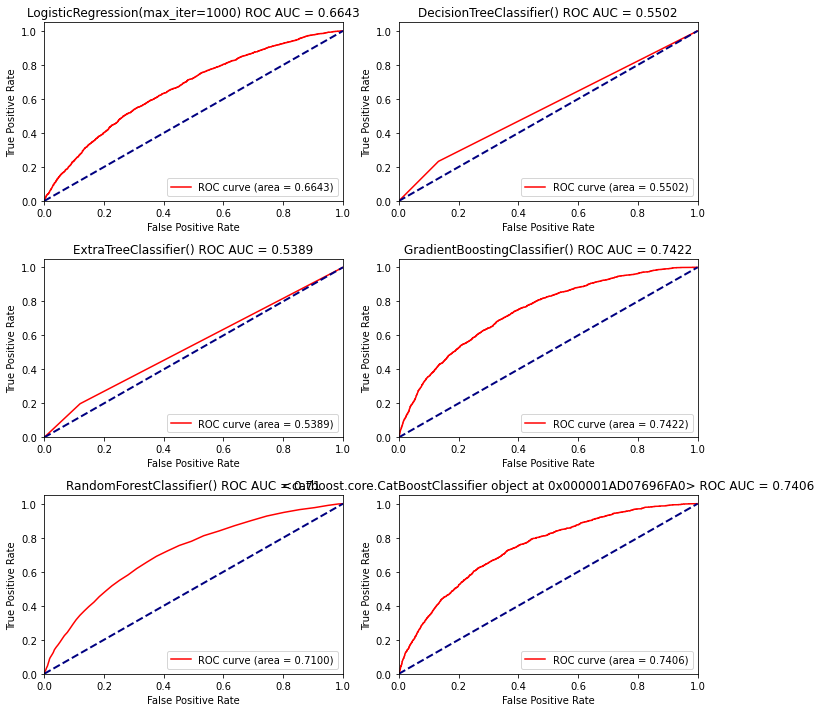

In [72]:
plt.figure(figsize=[10, 10])
k = 1
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    
    plt.subplot(3, 2, k)
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    name = model 
    num = float('{:.4f}'.format(roc_auc))
    
    plt.title(F"{name} ROC AUC = {num}")
    plt.legend(loc="lower right")
    k+=1
plt.tight_layout()
plt.show()

## Анализ важных признаков (Shap values)

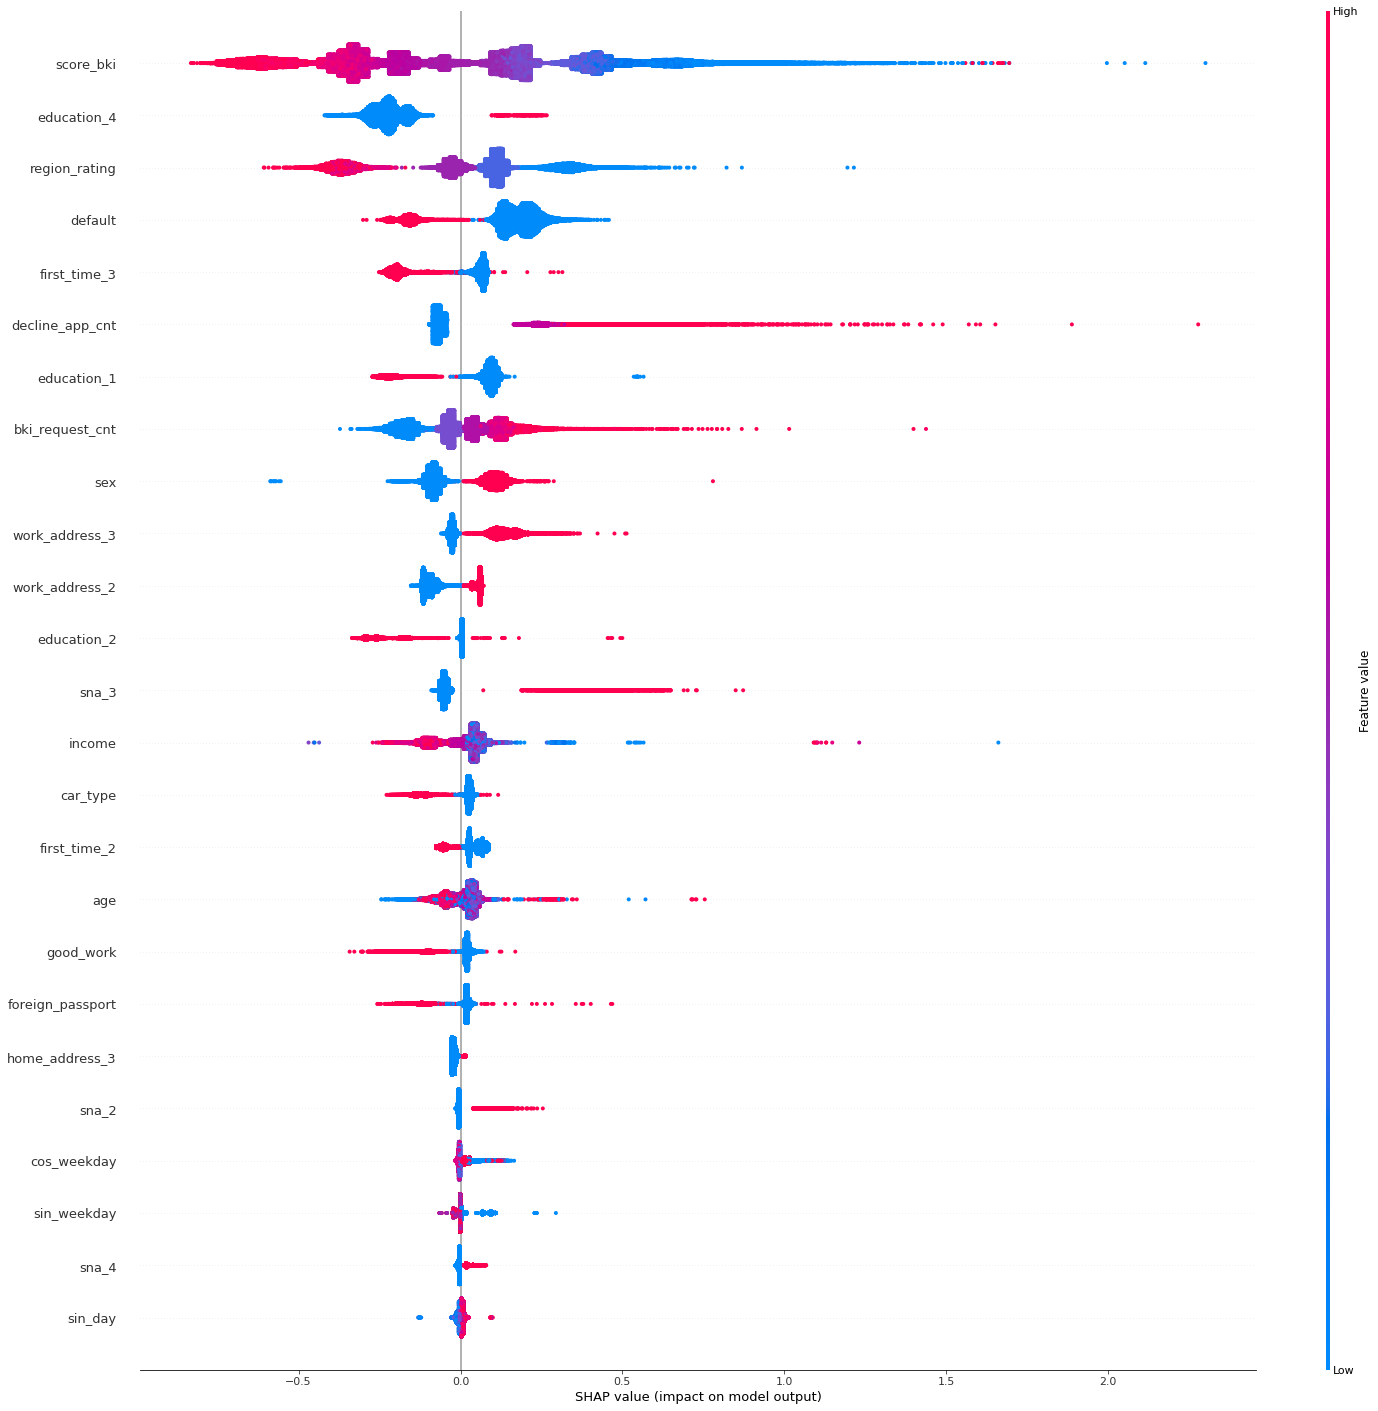

In [73]:
# SHapley Additive explanation:

shap_test = shap.TreeExplainer(gboost).shap_values(df)
shap.summary_plot(shap_test, df,
                      max_display=25, plot_size=None)

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точки на графике, тем выше значения фичи в ней

- чем больше значение признака score_bki, тем больше вероятность дефолта;
- чем больше значение признака age, тем меньше вероятность дефолта.

# Новые признаки

## Полиномиальные

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [74]:
df_pol = df[['score_bki','age','income']]

polynom = PolynomialFeatures(degree=2).fit(df_pol)
data = pd.DataFrame(polynom.transform(df_pol), 
                                    columns=polynom.get_feature_names_out(df_pol.columns))

data.drop(['1','score_bki', 'age', 'income'], axis=1, inplace=True)

polynom_df = pd.concat([data,df],axis=1)
polynom_df

score_bki^2  score_bki age  score_bki income     age^2  age income  \
0         0.000014       0.000016          0.000013  0.000017    0.000014   
1         0.000008       0.000012          0.000010  0.000017    0.000014   
2         0.000007       0.000009          0.000010  0.000011    0.000012   
3         0.000015       0.000015          0.000013  0.000016    0.000013   
4         0.000005       0.000009          0.000009  0.000015    0.000014   
...            ...            ...               ...       ...         ...   
73794     0.000011       0.000013          0.000012  0.000015    0.000013   
73795     0.000015       0.000014          0.000015  0.000014    0.000015   
73796     0.000008       0.000010          0.000011  0.000012    0.000013   
73797     0.000008       0.000009          0.000009  0.000012    0.000011   
73798     0.000011       0.000012          0.000012  0.000013    0.000013   

       income^2  sex       age  car  car_type  ...  sna_4  first_time_2  \
0      0.000012    1  0.004160    1         1  ...      1             0   
1      0.000012    0  0.004111    0         0  ...      1             0   
2      0.000013    1  0.003271    1         0  ...      0             0   
3      0.000011    0  0.004005    0         0  ...      0             0   
4      0.000013    1  0.003907    0         0  ...      0             0   
...         ...  ...       ...  ...       ...  ...    ...           ...   
73794  0.000012    0  0.003844    0         0  ...      1             0   
73795  0.000016    1  0.003753    1         1  ...      0             0   
73796  0.000014    1  0.003480    0         0  ...      0             1   
73797  0.000011    0  0.003415    0         0  ...      0             0   
73798  0.000013    1  0.003570    0         0  ...      0             0   

       first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0                 0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1                 0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2                 0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3                 1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4                 0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   
...             ...           ...           ...           ...           ...   
73794             0             1 -1.000000e+00 -1.836970e-16  8.660254e-01   
73795             0             1 -1.000000e+00 -1.836970e-16  0.000000e+00   
73796             0             0 -2.449294e-16  1.000000e+00  8.660254e-01   
73797             1             0  1.000000e+00  6.123234e-17 -8.660254e-01   
73798             1             0  1.000000e+00  6.123234e-17  1.224647e-16   

       cos_weekday   sin_day   cos_day  
0              0.5  0.201299  0.979530  
1             -0.5  0.651372 -0.758758  
2              0.5  0.201299  0.979530  
3             -1.0 -0.998717 -0.050649  
4             -0.5 -0.485302 -0.874347  
...            ...       ...       ...  
73794          0.5  0.724793  0.688967  
73795          1.0 -0.988468  0.151428  
73796          0.5 -0.968077 -0.250653  
73797          0.5  0.724793  0.688967  
73798         -1.0 -0.998717 -0.050649  

[73799 rows x 39 columns]

In [75]:
X = polynom_df.drop('default', axis=1)
y = polynom_df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

In [76]:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T


def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)
df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

Вывод: Добавление полиномиальных признаков значительно не улучшило качество модели.

## Объединение 2-х признаков

In [77]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

In [78]:
df[['car', 'car_type']]

car  car_type
0        1         1
1        0         0
2        1         0
3        0         0
4        0         0
...    ...       ...
73794    0         0
73795    1         1
73796    0         0
73797    0         0
73798    0         0

[73799 rows x 2 columns]

In [79]:
# сократим размерность матрицы без потери информации
# 0 - нет машины, 1 - есть отечественна машина, 2 - есть иномарка
df_car = df.copy(deep=True)
df_car['car_comb'] = df_car['car'] + df_car['car_type']
# df_car['car_comb'] = df_car['car_comb'].astype('category')
df_car.drop(['car', 'car_type'], axis=1, inplace=True)
df_car

sex       age  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
0        1  0.004160         0.000000          0   0.003756         0.002326   
1        0  0.004111         0.000000          0   0.002865         0.004651   
2        1  0.003271         0.010272          0   0.002633         0.002326   
3        0  0.004005         0.000000          0   0.003847         0.003686   
4        1  0.003907         0.000000          1   0.002327         0.002326   
...    ...       ...              ...        ...        ...              ...   
73794    0  0.003844         0.000000          0   0.003351         0.004651   
73795    1  0.003753         0.000000          0   0.003848         0.002326   
73796    1  0.003480         0.000000          0   0.002828         0.005400   
73797    0  0.003415         0.000000          1   0.002766         0.004651   
73798    1  0.003570         0.000000          0   0.003299         0.003686   

       region_rating    income  foreign_passport  default  ...  first_time_2  \
0           0.003162  0.003478                 0        0  ...             0   
1           0.003162  0.003497                 0        0  ...             0   
2           0.005059  0.003660                 1        0  ...             0   
3           0.003162  0.003270                 0        0  ...             0   
4           0.003794  0.003660                 1        0  ...             0   
...              ...       ...               ...      ...  ...           ...   
73794       0.003162  0.003458                 0        0  ...             0   
73795       0.003162  0.003960                 0        0  ...             0   
73796       0.005059  0.003804                 0        0  ...             1   
73797       0.003162  0.003363                 0        1  ...             0   
73798       0.003162  0.003595                 0        0  ...             0   

       first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0                 0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1                 0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2                 0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3                 1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4                 0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   
...             ...           ...           ...           ...           ...   
73794             0             1 -1.000000e+00 -1.836970e-16  8.660254e-01   
73795             0             1 -1.000000e+00 -1.836970e-16  0.000000e+00   
73796             0             0 -2.449294e-16  1.000000e+00  8.660254e-01   
73797             1             0  1.000000e+00  6.123234e-17 -8.660254e-01   
73798             1             0  1.000000e+00  6.123234e-17  1.224647e-16   

       cos_weekday   sin_day   cos_day  car_comb  
0              0.5  0.201299  0.979530         2  
1             -0.5  0.651372 -0.758758         0  
2              0.5  0.201299  0.979530         1  
3             -1.0 -0.998717 -0.050649         0  
4             -0.5 -0.485302 -0.874347         0  
...            ...       ...       ...       ...  
73794          0.5  0.724793  0.688967         0  
73795          1.0 -0.988468  0.151428         2  
73796          0.5 -0.968077 -0.250653         0  
73797          0.5  0.724793  0.688967         0  
73798         -1.0 -0.998717 -0.050649         0  

[73799 rows x 32 columns]

In [80]:
print(df_car.columns)
df_car['car_comb'].unique()

Index(['sex', 'age', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'region_rating', 'income', 'foreign_passport',
       'default', 'app_passed_days', 'education_1', 'education_2',
       'education_3', 'education_4', 'home_address_2', 'home_address_3',
       'work_address_2', 'work_address_3', 'sna_2', 'sna_3', 'sna_4',
       'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day',
       'car_comb'],
      dtype='object')


array([2, 0, 1])

In [81]:
X = df_car.drop('default', axis=1)
y = df_car['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

In [82]:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T


def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)
df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

Вывод: объединение двух признаков в один не изменил метрики качества - метрики остались практически такими же. Некторое даже понизились.

## PCA и Кластеризация

In [83]:
df_clus = df.copy(deep=True)

X = df_clus.drop('default', axis=1)
y = df_clus['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

len(X.columns) # кол-во признаков (компонент)

32

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. 

In [84]:
components = [14, 15, 16, 18, 20, 24, 28, 30] 

for i in components:
    pca = PCA(n_components=i, random_state = 123)
    X_pca = pca.fit_transform(X)
    print('Num_comp = ', i, 'Var = ', pca.explained_variance_ratio_.sum())
    
# Доля информации (доля от общей дисперсии): explained_variance_ratio_

Num_comp =  14 Var =  0.8975600287993943
Num_comp =  15 Var =  0.9170575199464004
Num_comp =  16 Var =  0.9343957007960171
Num_comp =  18 Var =  0.9655563581223181
Num_comp =  20 Var =  0.9833480521683989
Num_comp =  24 Var =  0.999548793851325
Num_comp =  28 Var =  0.9999997716170725
Num_comp =  30 Var =  0.9999999805683734


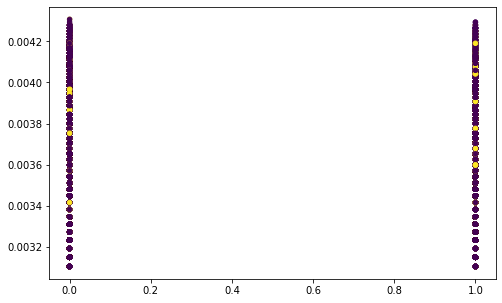

In [85]:
# Минимальное кол-во компонент = 15

pca = PCA(n_components=15, random_state = 123)
X_pca = pca.fit_transform(X)

# Визуализация данных в проекции на первые две главные компоненты.
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=y, s=20, cmap='viridis');

### KMeans

Кластеризация данных методом KMeans на модели со сниженной размерностью с помощью PCA:

In [86]:
kmeans = KMeans(n_clusters=2, n_init = 100, random_state=123)
kmeans.fit(X)

kmeans.labels_

array([0, 1, 0, ..., 1, 1, 1])

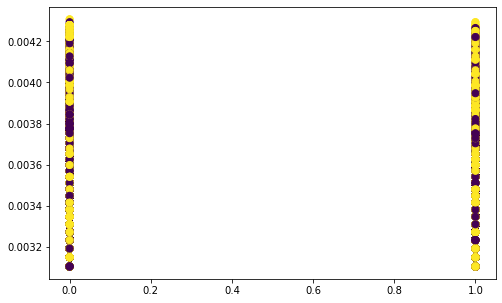

In [87]:
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=kmeans.labels_, s=50, cmap='viridis')

In [88]:
# Метрики качества кластеризации KMeans

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, kmeans.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, kmeans.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

Homogeneity: 0.008
Completeness: 0.005
V-measure: 0.006
Adjusted Rand-Index: -0.013
Adjusted mutual info score: 0.006
Silhouette Coefficient: 0.100


Качество кластеризации ***методом KMeans*** оказалось очень низким.


 ⏩ **Homogeneity:** (однородность / точность) - каждый кластер содержит только членов одного класса. От 0 до 1. Чем выше, тем лучше.

 ⏩ **Completeness:** (полнота) - все члены данного класса относятся к одному кластеру.

 ⏩ **V-measure:** (гармоническое среднее значение между точностью и полнотой) - достигает максимума при максимальной полноте и точности, и близка к нулю, если один из аргументов близок к нулю.

 ⏩ **Adjusted Rand-Index:** функция, которая измеряет сходство двух назначений, игнорируя перестановки, т.е. вносит поправку на случайность мест значений в выборке. Диапазон составляет [0, 1] для нескорректированного индекса 'rand_score' и [-1, 1] для скорректированного индекса 'adjusted_rand_score'.

  ⏩ **Adjusted mutual info score:** Мера согласованности. Диапазон составляет [0, 1].

   ⏩ **Silhouette Coefficient:** The best value is 1 and the worst value is -1. Values 
near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

### SpectralBiclustering

In [89]:
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(X)

SpectralBiclustering(init='k-means++', method='bistochastic',
                     mini_batch=False, n_best=3, n_clusters=2, n_components=6,
                     n_init=10, n_svd_vecs=None, random_state=0,
                     svd_method='randomized')

SpectralBiclustering(n_clusters=2, random_state=0)

In [90]:
clustering.row_labels_

array([1, 0, 1, ..., 1, 1, 1])

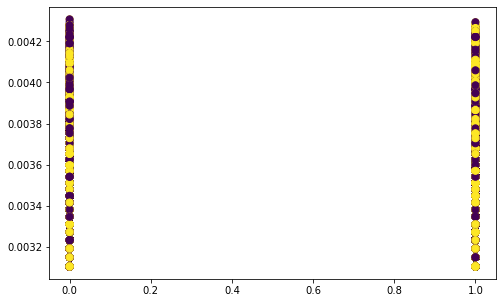

In [91]:
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=clustering.row_labels_, s=50, cmap='viridis')

In [92]:
# Метрики качества кластеризации SpectralBiclustering

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, clustering.row_labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, clustering.row_labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, clustering.row_labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, clustering.row_labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, clustering.row_labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, clustering.row_labels_, sample_size=1000))

Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
Adjusted mutual info score: 0.000
Silhouette Coefficient: 0.070


In [93]:
#  Кластеризация не дает хороших результатов при решении данной задачи.

# Подбор гиперпараметров (Grid search)

In [92]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

## LogisticRegression

In [107]:
lr = LogisticRegression()

params_lr = [{
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear'],
    'multi_class': ['ovr'],
    'max_iter': np.arange(100, 500, 100)
}, {
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'multi_class': ['ovr'],
    'max_iter': np.arange(100, 500, 100)
# }, {
#     'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['elasticnet'],
#     'class_weight': [None, 'balanced'],
#     'solver': ['saga'],
#     'multi_class': ['ovr'],
#     'l1_ratio' : [0.25, 0.5, 0.75],
#     'max_iter': np.arange(100, 500, 100)
}]

cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_lr = GridSearchCV(lr, params_lr,
                       scoring='roc_auc', cv=cv, verbose=2)

# производим обучение по сетке
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s


[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class

[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_

[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; to

[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   7.1s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   5.8s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   9.7s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.8s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   5.5s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   9.5s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, so

[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=  10.6s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.2s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.2s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.0s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.4s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.5s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.1s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=1000, class_weight=balanced, 

[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=b

[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr,

[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, ma

[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=o

[CV] END C=0.001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=balanced,

[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, s

[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbf

[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, 

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, pena

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-c

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; t

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; t

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.3s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.7s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.3s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.6s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.7s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.3s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.6s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.2s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.0s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=100, mul

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.7s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=balanced, max_iter=200,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.6s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.1s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=300,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.5s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.0s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.3s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=400,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.8s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.9s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.6s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.9s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.4s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.9s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.6s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   9.4s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.6s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=  10.2s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.9s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.5s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.1s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.4s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.8s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.4s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.8s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.2s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.0s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.3s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.3s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.2s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.4s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000],
                          'class_weight': [None, 'balanced'],
                          'max_iter': array([100, 200, 300, 400]),
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000],
                          'class_weight': [None, 'balanced'],
                          'max_iter': array([100, 200, 300, 400]),
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             scoring='roc_auc', verbose=2)

In [109]:
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.7326670691374731
{'C': 1000, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [111]:
best_params = {'C': 1000, 'class_weight': 'balanced', 
               'max_iter': 100, 'multi_class': 'ovr', 
               'penalty': 'l1', 'solver': 'liblinear'}

In [114]:
lr_model = LogisticRegression(**best_params)
%time lr_model.fit(X_train, y_train)

y_pred_gr = lr_model.predict(X_test)
y_score_gr = lr_model.predict_proba(X_test)[:,1]

Wall time: 10.3 s


In [115]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7416221653773317
precision: 0.23085319265053666
accuracy: 0.6725609756097561
recall: 0.6771611526147279
f1: 0.3443223443223444
logloss: 11.309572290957872


## DecisionTreeClassifier

In [116]:
from sklearn.datasets import make_moons

In [117]:
tree = DecisionTreeClassifier(random_state=42)

params_tree = {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}

grid_tree = GridSearchCV(tree, params_tree, scoring='roc_auc', verbose=1, cv=5)
grid_tree.fit(X_train, y_train)

0it [03:34, ?it/s]

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=1)

In [118]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.6943220792642709
{'max_leaf_nodes': 60, 'min_samples_split': 2}


In [119]:
grid_tree.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=60, random_state=42)

In [120]:
best_params = {'max_leaf_nodes': 60, 'min_samples_split': 2}

In [121]:
tree_model = DecisionTreeClassifier(**best_params, random_state=42)
%time tree_model.fit(X_train, y_train)

y_pred_gr = tree_model.predict(X_test)
y_score_gr = tree_model.predict_proba(X_test)[:,1]

Wall time: 215 ms


In [122]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7078555922049212
precision: 0.21428571428571427
accuracy: 0.8719512195121951
recall: 0.0032017075773745998
f1: 0.006309148264984228
logloss: 4.422649388721183


In [124]:
from sklearn.tree import export_graphviz

export_graphviz( 
 grid_tree.best_estimator_,
 out_file=('tree.dot'),
 feature_names=None,
 class_names=None,
 filled=True,
)

In [133]:
# ! pip install pydot

In [139]:
conda install graphviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\pato2\anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.3.29  |       haa95532_1         122 KB
    graphviz-2.38              |       hfd603c8_2        29.3 MB
    ------------------------------------------------------------
                                           Total:        29.4 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/win-64::graphviz-2.38-hfd603c8_2

The following packages will be UPDATED:

  ca-certificates                      2022.3.29-haa95532_0 --> 2022.3.29-haa95532_1




graphviz-2.38        | 29.3 MB   |            |   0% 
graphviz-2.38        | 29.3 MB   |            |   0% 
graphviz-2.38        | 29.3 MB   |            |   1% 
graphviz-2.38        | 29.3 MB   | 1  

In [140]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


![jupyter](./tree.png)

## ExtraTreeClassifier

In [142]:
extra_tree = ExtraTreeClassifier(random_state=160)

params_extree = {'max_depth': np.arange(4, 8, 1),
                 'min_samples_leaf': [2, 3, 4, 5],
                 'max_features' : [None, 'sqrt', 'log2']                 
                }

grid_extree = GridSearchCV(extra_tree, params_extree, scoring='roc_auc',
                       cv=5, verbose=1)

grid_extree.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=ExtraTreeClassifier(random_state=160),
             param_grid={'max_depth': array([4, 5, 6, 7]),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5]},
             scoring='roc_auc', verbose=1)

In [143]:
print(grid_extree.best_score_)
print(grid_extree.best_params_)

0.6937721517811559
{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5}


In [144]:
grid_extree.best_estimator_

ExtraTreeClassifier(max_depth=7, max_features=None, min_samples_leaf=5,
                    random_state=160)

In [146]:
best_params = {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5}

In [147]:
extree_model = ExtraTreeClassifier(**best_params, random_state=160)
%time extree_model.fit(X_train, y_train)

y_pred_gr = extree_model.predict(X_test)
y_score_gr = extree_model.predict_proba(X_test)[:,1]

Wall time: 205 ms


In [148]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7013110080666334
precision: 0.29545454545454547
accuracy: 0.8718157181571816
recall: 0.006937033084311633
f1: 0.013555787278415016
logloss: 4.427329927282612


## GradientBoostingClassifier

In [149]:
gboost = GradientBoostingClassifier()

params_gb = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

grid_gb = GridSearchCV(gboost, params_gb, scoring='roc_auc',
                       cv=5, verbose=1)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             scoring='roc_auc', verbose=1)

In [150]:
print(grid_gb.best_score_)
print(grid_gb.best_params_)

0.7325820960395062
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}


In [151]:
grid_gb.best_estimator_

GradientBoostingClassifier(max_depth=1, n_estimators=500)

In [161]:
best_params = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}

In [162]:
gb_model = GradientBoostingClassifier(**best_params)
%time gb_model.fit(X_train, y_train)

y_pred_gr = gb_model.predict(X_test)
y_score_gr = gb_model.predict_proba(X_test)[:,1]

Wall time: 13.3 s


In [163]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7420224616458491
precision: 0.4647887323943662
accuracy: 0.8726964769647696
recall: 0.017609391675560297
f1: 0.0339331619537275
logloss: 4.396909974982353


## RandomForestClassifier

In [164]:
rforest = RandomForestClassifier()

params_rf = {'n_estimators': range (10, 51, 10),
             'max_depth': range (1,13, 2),
             'min_samples_leaf': range (1,8),
             'min_samples_split': range (2,10,2),
             'random_state': [0]}

grid_rf = GridSearchCV(rforest, params_rf, scoring='roc_auc',
                       cv=5, verbose=1)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10),
                         'random_state': [0]},
             scoring='roc_auc', verbose=1)

In [165]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.7270287439404122
{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}


In [166]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=6, n_estimators=50,
                       random_state=0)

In [167]:
best_params = {'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}

In [170]:
rf_model = RandomForestClassifier(**best_params)
%time rf_model.fit(X_train, y_train)

y_pred_gr = rf_model.predict(X_test)
y_score_gr = rf_model.predict_proba(X_test)[:,1]

Wall time: 1.4 s


In [171]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7341593409806146
precision: 0.0
accuracy: 0.8730352303523036
recall: 0.0
f1: 0.0
logloss: 4.385207788893132


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



## CatBoostClassifier

In [172]:
catboo = CatBoostClassifier(silent=True)

params_cb = {'depth': [4, 6, 8, 9, 10],
        'iterations': [100, 150, 200, 350],
        'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5],
        'l2_leaf_reg': np.arange(1, 10,2),
        'early_stopping_rounds' : np.arange(10, 50, 10) }

grid_cb = GridSearchCV(catboo, params_cb, scoring='roc_auc',
                       cv=5, verbose=1)

grid_cb.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001733BE6D2B0>,
             param_grid={'depth': [4, 6, 8, 9, 10],
                         'early_stopping_rounds': array([10, 20, 30, 40]),
                         'iterations': [100, 150, 200, 350],
                         'l2_leaf_reg': array([1, 3, 5, 7, 9]),
                         'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]},
             scoring='roc_auc', verbose=1)

In [173]:
print(grid_cb.best_score_)
print(grid_cb.best_params_)

0.7358083160139712
{'depth': 4, 'early_stopping_rounds': 10, 'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}


In [174]:
grid_cb.best_estimator_

In [183]:
best_params = {'depth': 4, 'early_stopping_rounds': 10, 'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

In [184]:
cb_model = CatBoostClassifier(**best_params)
%time cb_model.fit(X_train, y_train)

y_pred_rf = cb_model.predict(X_test)
y_score_rf = cb_model.predict_proba(X_test)[:,1]

0:	learn: 0.6562792	total: 11.8ms	remaining: 4.11s
1:	learn: 0.6232155	total: 25.2ms	remaining: 4.38s
2:	learn: 0.5940063	total: 37.7ms	remaining: 4.36s
3:	learn: 0.5671203	total: 48.7ms	remaining: 4.21s
4:	learn: 0.5441709	total: 60ms	remaining: 4.14s
5:	learn: 0.5230385	total: 70.8ms	remaining: 4.06s
6:	learn: 0.5035230	total: 81.2ms	remaining: 3.98s
7:	learn: 0.4881912	total: 90.9ms	remaining: 3.89s
8:	learn: 0.4747613	total: 102ms	remaining: 3.85s
9:	learn: 0.4609842	total: 113ms	remaining: 3.83s
10:	learn: 0.4502544	total: 125ms	remaining: 3.85s
11:	learn: 0.4401094	total: 135ms	remaining: 3.8s
12:	learn: 0.4307143	total: 146ms	remaining: 3.79s
13:	learn: 0.4225785	total: 160ms	remaining: 3.83s
14:	learn: 0.4158507	total: 171ms	remaining: 3.83s
15:	learn: 0.4099358	total: 183ms	remaining: 3.82s
16:	learn: 0.4042792	total: 195ms	remaining: 3.81s
17:	learn: 0.3995778	total: 204ms	remaining: 3.77s
18:	learn: 0.3949067	total: 217ms	remaining: 3.78s
19:	learn: 0.3910066	total: 229ms	re

174:	learn: 0.3385096	total: 2.22s	remaining: 2.22s
175:	learn: 0.3384930	total: 2.23s	remaining: 2.2s
176:	learn: 0.3384574	total: 2.24s	remaining: 2.19s
177:	learn: 0.3384315	total: 2.25s	remaining: 2.17s
178:	learn: 0.3383999	total: 2.26s	remaining: 2.16s
179:	learn: 0.3383799	total: 2.28s	remaining: 2.15s
180:	learn: 0.3383536	total: 2.29s	remaining: 2.14s
181:	learn: 0.3383291	total: 2.3s	remaining: 2.12s
182:	learn: 0.3383039	total: 2.31s	remaining: 2.11s
183:	learn: 0.3382814	total: 2.32s	remaining: 2.1s
184:	learn: 0.3382533	total: 2.34s	remaining: 2.08s
185:	learn: 0.3382219	total: 2.35s	remaining: 2.07s
186:	learn: 0.3382008	total: 2.36s	remaining: 2.06s
187:	learn: 0.3381742	total: 2.38s	remaining: 2.05s
188:	learn: 0.3381516	total: 2.39s	remaining: 2.04s
189:	learn: 0.3381162	total: 2.4s	remaining: 2.02s
190:	learn: 0.3380980	total: 2.41s	remaining: 2.01s
191:	learn: 0.3380706	total: 2.42s	remaining: 2s
192:	learn: 0.3380442	total: 2.44s	remaining: 1.98s
193:	learn: 0.33801

345:	learn: 0.3345020	total: 4.41s	remaining: 51ms
346:	learn: 0.3344794	total: 4.42s	remaining: 38.3ms
347:	learn: 0.3344653	total: 4.43s	remaining: 25.5ms
348:	learn: 0.3344404	total: 4.45s	remaining: 12.7ms
349:	learn: 0.3344101	total: 4.46s	remaining: 0us
Wall time: 4.67 s


In [178]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [185]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7341593409806146
precision: 0.0
accuracy: 0.8730352303523036
recall: 0.0
f1: 0.0
logloss: 4.385207788893132


## Результаты Grid Search

In [186]:
models = [lr_model, tree_model, extree_model, gb_model, rf_model, cb_model]

# Создание таблицы с метриками:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)

# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T

0:	learn: 0.6562792	total: 12.1ms	remaining: 4.24s
1:	learn: 0.6232155	total: 24.6ms	remaining: 4.29s
2:	learn: 0.5940063	total: 38.5ms	remaining: 4.45s
3:	learn: 0.5671203	total: 50.7ms	remaining: 4.39s
4:	learn: 0.5441709	total: 63.7ms	remaining: 4.39s
5:	learn: 0.5230385	total: 75.3ms	remaining: 4.32s
6:	learn: 0.5035230	total: 87.3ms	remaining: 4.28s
7:	learn: 0.4881912	total: 97.7ms	remaining: 4.18s
8:	learn: 0.4747613	total: 109ms	remaining: 4.13s
9:	learn: 0.4609842	total: 120ms	remaining: 4.08s
10:	learn: 0.4502544	total: 133ms	remaining: 4.1s
11:	learn: 0.4401094	total: 145ms	remaining: 4.08s
12:	learn: 0.4307143	total: 157ms	remaining: 4.06s
13:	learn: 0.4225785	total: 169ms	remaining: 4.05s
14:	learn: 0.4158507	total: 181ms	remaining: 4.04s
15:	learn: 0.4099358	total: 192ms	remaining: 4.01s
16:	learn: 0.4042792	total: 203ms	remaining: 3.97s
17:	learn: 0.3995778	total: 212ms	remaining: 3.91s
18:	learn: 0.3949067	total: 224ms	remaining: 3.9s
19:	learn: 0.3910066	total: 236ms	r

177:	learn: 0.3384315	total: 2.12s	remaining: 2.05s
178:	learn: 0.3383999	total: 2.13s	remaining: 2.03s
179:	learn: 0.3383799	total: 2.14s	remaining: 2.02s
180:	learn: 0.3383536	total: 2.15s	remaining: 2s
181:	learn: 0.3383291	total: 2.16s	remaining: 1.99s
182:	learn: 0.3383039	total: 2.17s	remaining: 1.98s
183:	learn: 0.3382814	total: 2.18s	remaining: 1.97s
184:	learn: 0.3382533	total: 2.19s	remaining: 1.96s
185:	learn: 0.3382219	total: 2.2s	remaining: 1.94s
186:	learn: 0.3382008	total: 2.22s	remaining: 1.93s
187:	learn: 0.3381742	total: 2.23s	remaining: 1.92s
188:	learn: 0.3381516	total: 2.24s	remaining: 1.91s
189:	learn: 0.3381162	total: 2.25s	remaining: 1.9s
190:	learn: 0.3380980	total: 2.26s	remaining: 1.88s
191:	learn: 0.3380706	total: 2.28s	remaining: 1.87s
192:	learn: 0.3380442	total: 2.29s	remaining: 1.86s
193:	learn: 0.3380175	total: 2.3s	remaining: 1.85s
194:	learn: 0.3379946	total: 2.31s	remaining: 1.84s
195:	learn: 0.3379487	total: 2.33s	remaining: 1.83s
196:	learn: 0.3379

337:	learn: 0.3347086	total: 4.07s	remaining: 144ms
338:	learn: 0.3346861	total: 4.08s	remaining: 132ms
339:	learn: 0.3346589	total: 4.09s	remaining: 120ms
340:	learn: 0.3346255	total: 4.1s	remaining: 108ms
341:	learn: 0.3345885	total: 4.11s	remaining: 96.3ms
342:	learn: 0.3345729	total: 4.13s	remaining: 84.2ms
343:	learn: 0.3345551	total: 4.14s	remaining: 72.2ms
344:	learn: 0.3345272	total: 4.15s	remaining: 60.2ms
345:	learn: 0.3345020	total: 4.17s	remaining: 48.2ms
346:	learn: 0.3344794	total: 4.18s	remaining: 36.1ms
347:	learn: 0.3344653	total: 4.19s	remaining: 24.1ms
348:	learn: 0.3344404	total: 4.2s	remaining: 12ms
349:	learn: 0.3344101	total: 4.21s	remaining: 0us


In [187]:
def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

0:	learn: 0.6562792	total: 12.5ms	remaining: 4.36s
1:	learn: 0.6232155	total: 26.6ms	remaining: 4.63s
2:	learn: 0.5940063	total: 40.9ms	remaining: 4.74s
3:	learn: 0.5671203	total: 53.5ms	remaining: 4.63s
4:	learn: 0.5441709	total: 65.4ms	remaining: 4.51s
5:	learn: 0.5230385	total: 76.9ms	remaining: 4.41s
6:	learn: 0.5035230	total: 88.3ms	remaining: 4.33s
7:	learn: 0.4881912	total: 97.6ms	remaining: 4.17s
8:	learn: 0.4747613	total: 110ms	remaining: 4.16s
9:	learn: 0.4609842	total: 121ms	remaining: 4.1s
10:	learn: 0.4502544	total: 133ms	remaining: 4.09s
11:	learn: 0.4401094	total: 145ms	remaining: 4.08s
12:	learn: 0.4307143	total: 156ms	remaining: 4.04s
13:	learn: 0.4225785	total: 169ms	remaining: 4.05s
14:	learn: 0.4158507	total: 181ms	remaining: 4.04s
15:	learn: 0.4099358	total: 192ms	remaining: 4.01s
16:	learn: 0.4042792	total: 203ms	remaining: 3.98s
17:	learn: 0.3995778	total: 215ms	remaining: 3.96s
18:	learn: 0.3949067	total: 225ms	remaining: 3.92s
19:	learn: 0.3910066	total: 239ms	

162:	learn: 0.3389378	total: 1.96s	remaining: 2.25s
163:	learn: 0.3389047	total: 1.97s	remaining: 2.24s
164:	learn: 0.3388602	total: 1.99s	remaining: 2.23s
165:	learn: 0.3388010	total: 2s	remaining: 2.22s
166:	learn: 0.3387618	total: 2.01s	remaining: 2.2s
167:	learn: 0.3387183	total: 2.02s	remaining: 2.19s
168:	learn: 0.3386919	total: 2.04s	remaining: 2.18s
169:	learn: 0.3386670	total: 2.05s	remaining: 2.17s
170:	learn: 0.3386395	total: 2.06s	remaining: 2.16s
171:	learn: 0.3386126	total: 2.07s	remaining: 2.14s
172:	learn: 0.3385852	total: 2.08s	remaining: 2.13s
173:	learn: 0.3385457	total: 2.1s	remaining: 2.12s
174:	learn: 0.3385096	total: 2.11s	remaining: 2.11s
175:	learn: 0.3384930	total: 2.12s	remaining: 2.1s
176:	learn: 0.3384574	total: 2.13s	remaining: 2.08s
177:	learn: 0.3384315	total: 2.15s	remaining: 2.07s
178:	learn: 0.3383999	total: 2.16s	remaining: 2.06s
179:	learn: 0.3383799	total: 2.17s	remaining: 2.05s
180:	learn: 0.3383536	total: 2.21s	remaining: 2.06s
181:	learn: 0.3383

323:	learn: 0.3350390	total: 3.89s	remaining: 313ms
324:	learn: 0.3350088	total: 3.91s	remaining: 301ms
325:	learn: 0.3349827	total: 3.92s	remaining: 288ms
326:	learn: 0.3349603	total: 3.93s	remaining: 276ms
327:	learn: 0.3349270	total: 3.94s	remaining: 264ms
328:	learn: 0.3349019	total: 3.95s	remaining: 252ms
329:	learn: 0.3348824	total: 3.96s	remaining: 240ms
330:	learn: 0.3348553	total: 3.98s	remaining: 228ms
331:	learn: 0.3348311	total: 3.99s	remaining: 216ms
332:	learn: 0.3348040	total: 4s	remaining: 204ms
333:	learn: 0.3348027	total: 4.01s	remaining: 192ms
334:	learn: 0.3347793	total: 4.02s	remaining: 180ms
335:	learn: 0.3347511	total: 4.04s	remaining: 168ms
336:	learn: 0.3347279	total: 4.05s	remaining: 156ms
337:	learn: 0.3347086	total: 4.06s	remaining: 144ms
338:	learn: 0.3346861	total: 4.07s	remaining: 132ms
339:	learn: 0.3346589	total: 4.08s	remaining: 120ms
340:	learn: 0.3346255	total: 4.1s	remaining: 108ms
341:	learn: 0.3345885	total: 4.11s	remaining: 96.1ms
342:	learn: 0.3

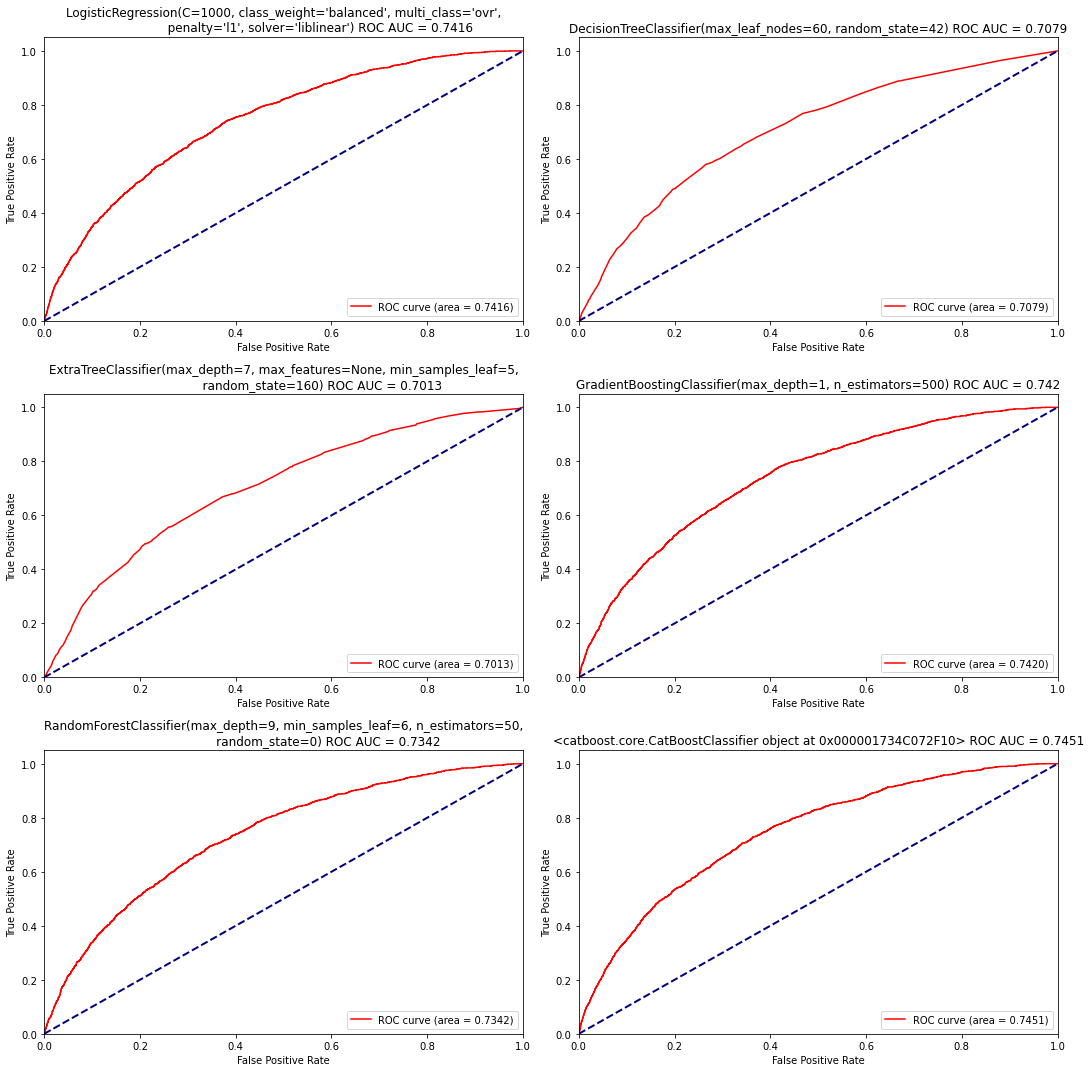

In [189]:
plt.figure(figsize=[15, 15])
k = 1
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    
    plt.subplot(3, 2, k)
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    name = model 
    num = float('{:.4f}'.format(roc_auc))
    
    plt.title(F"{name} ROC AUC = {num}")
    plt.legend(loc="lower right")
    k+=1
plt.tight_layout()
plt.show()

# Две лучшие модели:

In [ ]:
# CatBoost =>  Auc = 0.7451
# LogisticR =>  Auc = 0.7416
# GradientBoost - намеренно не учитывается в ансамбле

In [191]:
# LogisticR

lr_params = {'C': 1000, 'class_weight': 'balanced', 
               'max_iter': 100, 'multi_class': 'ovr', 
               'penalty': 'l1', 'solver': 'liblinear'}

best_lr = LogisticRegression(**lr_params)
best_lr.fit(X_train, y_train)

y_pred_lr = best_lr.predict(X_test)
y_score_lr = best_lr.predict_proba(X_test)[:,1]

In [278]:
# CatBoost

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb = CatBoostClassifier(**cb_params)

best_cb.fit(X_train, y_train)

y_pred_cb = best_cb.predict(X_test)
y_score_cb = best_cb.predict_proba(X_test)[:,1]

0:	learn: 0.6876942	total: 6.37ms	remaining: 2.22s
1:	learn: 0.6826755	total: 13.4ms	remaining: 2.33s
2:	learn: 0.6782443	total: 20.6ms	remaining: 2.38s
3:	learn: 0.6742410	total: 25.5ms	remaining: 2.21s
4:	learn: 0.6703410	total: 30.7ms	remaining: 2.12s
5:	learn: 0.6672089	total: 37.6ms	remaining: 2.15s
6:	learn: 0.6640477	total: 43.6ms	remaining: 2.14s
7:	learn: 0.6617435	total: 50.7ms	remaining: 2.17s
8:	learn: 0.6594000	total: 56.5ms	remaining: 2.14s
9:	learn: 0.6571092	total: 62ms	remaining: 2.11s
10:	learn: 0.6549865	total: 67.2ms	remaining: 2.07s
11:	learn: 0.6525194	total: 74ms	remaining: 2.08s
12:	learn: 0.6506009	total: 81.1ms	remaining: 2.1s
13:	learn: 0.6489365	total: 86.9ms	remaining: 2.08s
14:	learn: 0.6469328	total: 92.7ms	remaining: 2.07s
15:	learn: 0.6451304	total: 99.9ms	remaining: 2.08s
16:	learn: 0.6436060	total: 106ms	remaining: 2.07s
17:	learn: 0.6420764	total: 112ms	remaining: 2.07s
18:	learn: 0.6406949	total: 118ms	remaining: 2.06s
19:	learn: 0.6393693	total: 12

187:	learn: 0.5957094	total: 1.28s	remaining: 1.1s
188:	learn: 0.5956504	total: 1.29s	remaining: 1.1s
189:	learn: 0.5955840	total: 1.29s	remaining: 1.09s
190:	learn: 0.5955169	total: 1.3s	remaining: 1.08s
191:	learn: 0.5954456	total: 1.31s	remaining: 1.07s
192:	learn: 0.5953554	total: 1.31s	remaining: 1.07s
193:	learn: 0.5952120	total: 1.32s	remaining: 1.06s
194:	learn: 0.5950851	total: 1.33s	remaining: 1.06s
195:	learn: 0.5949835	total: 1.33s	remaining: 1.05s
196:	learn: 0.5949072	total: 1.34s	remaining: 1.04s
197:	learn: 0.5948118	total: 1.35s	remaining: 1.04s
198:	learn: 0.5946836	total: 1.36s	remaining: 1.03s
199:	learn: 0.5945819	total: 1.36s	remaining: 1.02s
200:	learn: 0.5944500	total: 1.37s	remaining: 1.02s
201:	learn: 0.5944006	total: 1.38s	remaining: 1.01s
202:	learn: 0.5943142	total: 1.39s	remaining: 1s
203:	learn: 0.5941794	total: 1.4s	remaining: 998ms
204:	learn: 0.5941027	total: 1.4s	remaining: 991ms
205:	learn: 0.5939768	total: 1.43s	remaining: 999ms
206:	learn: 0.593870

In [198]:
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * y_score_lr + (1 - alpha) * y_score_cb
#     print(alpha, res)
    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
        #print(pred)
    print('alpha:', alpha, 'score:', roc_auc_score(y_test, probs))
# print(pred)

alpha: 0.1 score: 0.745069521065692
alpha: 0.2 score: 0.745069521065692
alpha: 0.30000000000000004 score: 0.745069521065692
alpha: 0.4 score: 0.745069521065692
alpha: 0.5 score: 0.745069521065692
alpha: 0.6 score: 0.745069521065692
alpha: 0.7000000000000001 score: 0.745069521065692
alpha: 0.8 score: 0.745069521065692
alpha: 0.9 score: 0.745069521065692
alpha: 1.0 score: 0.745069521065692


**Вывод:** Ансамбль из CatBoost и LogisticR не превысил результат лучшей модели "CatBoost =>  Auc = 0.7451"

# Несбалансированность

In [281]:
# Запись метрик в таблицу
best_cb = CatBoostClassifier(**cb_params)

best_cb.fit(X_train, y_train)

y_pred_cb = best_cb.predict(X_test)
y_score_cb = best_cb.predict_proba(X_test)[:,1]

lst_cb = [] 
lst_1 = zip(*[iter(lst_cb)]*6)

lst_cb.append(roc_auc_score(y_test, probs))
lst_cb.append(accuracy_score(y_test, y_pred))
lst_cb.append(precision_score(y_test, y_pred, zero_division=0))
lst_cb.append(recall_score(y_test, y_pred, zero_division=0))
lst_cb.append(f1_score(y_test, y_pred, zero_division=0))
lst_cb.append(log_loss(y_test, y_pred))

df1 = pd.DataFrame(list(lst_1), columns=cols)

0:	learn: 0.6876942	total: 5.17ms	remaining: 1.8s
1:	learn: 0.6826755	total: 11.1ms	remaining: 1.94s
2:	learn: 0.6782443	total: 24.3ms	remaining: 2.81s
3:	learn: 0.6742410	total: 30.7ms	remaining: 2.65s
4:	learn: 0.6703410	total: 36.8ms	remaining: 2.54s
5:	learn: 0.6672089	total: 42.9ms	remaining: 2.46s
6:	learn: 0.6640477	total: 50.5ms	remaining: 2.48s
7:	learn: 0.6617435	total: 57ms	remaining: 2.44s
8:	learn: 0.6594000	total: 63.2ms	remaining: 2.39s
9:	learn: 0.6571092	total: 68.9ms	remaining: 2.34s
10:	learn: 0.6549865	total: 75.2ms	remaining: 2.32s
11:	learn: 0.6525194	total: 82.1ms	remaining: 2.31s
12:	learn: 0.6506009	total: 88.7ms	remaining: 2.3s
13:	learn: 0.6489365	total: 95.7ms	remaining: 2.29s
14:	learn: 0.6469328	total: 101ms	remaining: 2.26s
15:	learn: 0.6451304	total: 108ms	remaining: 2.26s
16:	learn: 0.6436060	total: 114ms	remaining: 2.23s
17:	learn: 0.6420764	total: 121ms	remaining: 2.22s
18:	learn: 0.6406949	total: 127ms	remaining: 2.21s
19:	learn: 0.6393693	total: 133

162:	learn: 0.5982104	total: 1.09s	remaining: 1.25s
163:	learn: 0.5981315	total: 1.1s	remaining: 1.24s
164:	learn: 0.5980595	total: 1.1s	remaining: 1.24s
165:	learn: 0.5979308	total: 1.11s	remaining: 1.23s
166:	learn: 0.5978309	total: 1.12s	remaining: 1.23s
167:	learn: 0.5977543	total: 1.12s	remaining: 1.22s
168:	learn: 0.5976617	total: 1.13s	remaining: 1.21s
169:	learn: 0.5975756	total: 1.14s	remaining: 1.2s
170:	learn: 0.5974769	total: 1.14s	remaining: 1.2s
171:	learn: 0.5973859	total: 1.15s	remaining: 1.19s
172:	learn: 0.5972905	total: 1.16s	remaining: 1.19s
173:	learn: 0.5971925	total: 1.17s	remaining: 1.18s
174:	learn: 0.5971025	total: 1.17s	remaining: 1.17s
175:	learn: 0.5970096	total: 1.18s	remaining: 1.16s
176:	learn: 0.5969103	total: 1.19s	remaining: 1.17s
177:	learn: 0.5967550	total: 1.2s	remaining: 1.16s
178:	learn: 0.5966873	total: 1.21s	remaining: 1.15s
179:	learn: 0.5965672	total: 1.21s	remaining: 1.14s
180:	learn: 0.5964901	total: 1.22s	remaining: 1.14s
181:	learn: 0.596

326:	learn: 0.5828045	total: 2.18s	remaining: 153ms
327:	learn: 0.5827492	total: 2.18s	remaining: 147ms
328:	learn: 0.5826805	total: 2.19s	remaining: 140ms
329:	learn: 0.5826103	total: 2.2s	remaining: 133ms
330:	learn: 0.5825290	total: 2.21s	remaining: 127ms
331:	learn: 0.5824344	total: 2.21s	remaining: 120ms
332:	learn: 0.5823650	total: 2.22s	remaining: 113ms
333:	learn: 0.5823020	total: 2.22s	remaining: 107ms
334:	learn: 0.5822348	total: 2.23s	remaining: 99.9ms
335:	learn: 0.5820856	total: 2.24s	remaining: 93.3ms
336:	learn: 0.5820019	total: 2.25s	remaining: 86.6ms
337:	learn: 0.5819976	total: 2.25s	remaining: 79.9ms
338:	learn: 0.5819122	total: 2.27s	remaining: 73.7ms
339:	learn: 0.5818747	total: 2.28s	remaining: 67ms
340:	learn: 0.5817870	total: 2.29s	remaining: 60.4ms
341:	learn: 0.5816704	total: 2.29s	remaining: 53.7ms
342:	learn: 0.5815840	total: 2.3s	remaining: 47ms
343:	learn: 0.5815801	total: 2.31s	remaining: 40.3ms
344:	learn: 0.5814862	total: 2.32s	remaining: 33.6ms
345:	le

Roc Auc  Accuracy  Precision  Recall        f1   Log loss
0  0.735938  0.672446   0.676102  0.6624  0.669181  11.313442

In [ ]:
# !pip install imblearn

In [94]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [95]:
from collections import Counter

X = df.drop('default', axis=1)
y = df['default']

print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 64427, 1: 9372})


In [96]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_ros)))

Resampled dataset shape Counter({0: 64427, 1: 64427})


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, stratify=y_ros, 
                                                    shuffle=True, random_state=RANDOM_SEED)

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb_ros = CatBoostClassifier(**cb_params)

best_cb_ros.fit(X_train, y_train)

y_pred_cb = best_cb_ros.predict(X_test)
y_score_cb = best_cb_ros.predict_proba(X_test)[:,1]

# Запись метрик в таблицу
lst_cb_ros = [] 
lst_2 = zip(*[iter(lst_cb_ros)]*6)

lst_cb_ros.append(roc_auc_score(y_test, y_score_cb))
lst_cb_ros.append(accuracy_score(y_test, y_pred_cb))
lst_cb_ros.append(precision_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(recall_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(f1_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(log_loss(y_test, y_pred_cb))

df2 = pd.DataFrame(list(lst_2), columns=cols)

0:	learn: 0.6880041	total: 9.73ms	remaining: 3.4s
1:	learn: 0.6828899	total: 18.6ms	remaining: 3.24s
2:	learn: 0.6781902	total: 27.5ms	remaining: 3.18s
3:	learn: 0.6739921	total: 35.8ms	remaining: 3.09s
4:	learn: 0.6705400	total: 44.5ms	remaining: 3.07s
5:	learn: 0.6673262	total: 54ms	remaining: 3.1s
6:	learn: 0.6640136	total: 63.3ms	remaining: 3.1s
7:	learn: 0.6612392	total: 71.6ms	remaining: 3.06s
8:	learn: 0.6587008	total: 80.3ms	remaining: 3.04s
9:	learn: 0.6562660	total: 90.2ms	remaining: 3.07s
10:	learn: 0.6540235	total: 101ms	remaining: 3.1s
11:	learn: 0.6519403	total: 110ms	remaining: 3.09s
12:	learn: 0.6496058	total: 121ms	remaining: 3.12s
13:	learn: 0.6473848	total: 129ms	remaining: 3.1s
14:	learn: 0.6455979	total: 136ms	remaining: 3.04s
15:	learn: 0.6437579	total: 145ms	remaining: 3.02s
16:	learn: 0.6422835	total: 154ms	remaining: 3.01s
17:	learn: 0.6407685	total: 163ms	remaining: 3s
18:	learn: 0.6391235	total: 171ms	remaining: 2.98s
19:	learn: 0.6379098	total: 179ms	remaini

165:	learn: 0.5959079	total: 1.5s	remaining: 1.67s
166:	learn: 0.5958392	total: 1.51s	remaining: 1.66s
167:	learn: 0.5957892	total: 1.52s	remaining: 1.65s
168:	learn: 0.5956818	total: 1.54s	remaining: 1.65s
169:	learn: 0.5955866	total: 1.54s	remaining: 1.64s
170:	learn: 0.5955445	total: 1.56s	remaining: 1.63s
171:	learn: 0.5954815	total: 1.57s	remaining: 1.62s
172:	learn: 0.5954191	total: 1.57s	remaining: 1.61s
173:	learn: 0.5953466	total: 1.58s	remaining: 1.6s
174:	learn: 0.5952471	total: 1.59s	remaining: 1.59s
175:	learn: 0.5951924	total: 1.6s	remaining: 1.58s
176:	learn: 0.5951024	total: 1.61s	remaining: 1.57s
177:	learn: 0.5950379	total: 1.62s	remaining: 1.56s
178:	learn: 0.5949932	total: 1.63s	remaining: 1.55s
179:	learn: 0.5949393	total: 1.64s	remaining: 1.54s
180:	learn: 0.5948572	total: 1.65s	remaining: 1.54s
181:	learn: 0.5947896	total: 1.65s	remaining: 1.53s
182:	learn: 0.5947323	total: 1.66s	remaining: 1.52s
183:	learn: 0.5946732	total: 1.67s	remaining: 1.51s
184:	learn: 0.5

327:	learn: 0.5856867	total: 3.05s	remaining: 204ms
328:	learn: 0.5856049	total: 3.06s	remaining: 195ms
329:	learn: 0.5855602	total: 3.07s	remaining: 186ms
330:	learn: 0.5855075	total: 3.08s	remaining: 177ms
331:	learn: 0.5854371	total: 3.09s	remaining: 168ms
332:	learn: 0.5853863	total: 3.1s	remaining: 158ms
333:	learn: 0.5853339	total: 3.11s	remaining: 149ms
334:	learn: 0.5852894	total: 3.12s	remaining: 140ms
335:	learn: 0.5852250	total: 3.13s	remaining: 130ms
336:	learn: 0.5851697	total: 3.14s	remaining: 121ms
337:	learn: 0.5851244	total: 3.15s	remaining: 112ms
338:	learn: 0.5850695	total: 3.16s	remaining: 102ms
339:	learn: 0.5850148	total: 3.17s	remaining: 93.1ms
340:	learn: 0.5849753	total: 3.17s	remaining: 83.8ms
341:	learn: 0.5849133	total: 3.18s	remaining: 74.4ms
342:	learn: 0.5848544	total: 3.19s	remaining: 65.1ms
343:	learn: 0.5847829	total: 3.2s	remaining: 55.8ms
344:	learn: 0.5847211	total: 3.21s	remaining: 46.5ms
345:	learn: 0.5846421	total: 3.22s	remaining: 37.2ms
346:	le

In [275]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_rus)))

Resampled dataset shape Counter({0: 9372, 1: 9372})


In [288]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, stratify=y_rus, 
                                                    shuffle=True, random_state=RANDOM_SEED)

best_cb_rus = CatBoostClassifier(**cb_params)

best_cb_rus.fit(X_train, y_train)

y_pred_cb = best_cb_rus.predict(X_test)
y_score_cb = best_cb_rus.predict_proba(X_test)[:,1]

# Запись метрик в таблицу
lst_cb_rus = [] 
lst_3 = zip(*[iter(lst_cb_rus)]*6)

lst_cb_rus.append(roc_auc_score(y_test, y_score_cb))
lst_cb_rus.append(accuracy_score(y_test, y_pred_cb))
lst_cb_rus.append(precision_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(recall_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(f1_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(log_loss(y_test, y_pred_cb))

df3 = pd.DataFrame(list(lst_3), columns=cols)

0:	learn: 0.6876942	total: 15ms	remaining: 5.25s
1:	learn: 0.6826755	total: 21.3ms	remaining: 3.71s
2:	learn: 0.6782443	total: 27.4ms	remaining: 3.17s
3:	learn: 0.6742410	total: 34.1ms	remaining: 2.95s
4:	learn: 0.6703410	total: 40.3ms	remaining: 2.78s
5:	learn: 0.6672089	total: 46.8ms	remaining: 2.68s
6:	learn: 0.6640477	total: 53.4ms	remaining: 2.61s
7:	learn: 0.6617435	total: 60.4ms	remaining: 2.58s
8:	learn: 0.6594000	total: 66.1ms	remaining: 2.5s
9:	learn: 0.6571092	total: 72.2ms	remaining: 2.45s
10:	learn: 0.6549865	total: 78.9ms	remaining: 2.43s
11:	learn: 0.6525194	total: 85.8ms	remaining: 2.42s
12:	learn: 0.6506009	total: 93.1ms	remaining: 2.41s
13:	learn: 0.6489365	total: 100ms	remaining: 2.4s
14:	learn: 0.6469328	total: 105ms	remaining: 2.34s
15:	learn: 0.6451304	total: 111ms	remaining: 2.31s
16:	learn: 0.6436060	total: 116ms	remaining: 2.26s
17:	learn: 0.6420764	total: 122ms	remaining: 2.26s
18:	learn: 0.6406949	total: 129ms	remaining: 2.24s
19:	learn: 0.6393693	total: 136m

187:	learn: 0.5957094	total: 1.29s	remaining: 1.11s
188:	learn: 0.5956504	total: 1.29s	remaining: 1.1s
189:	learn: 0.5955840	total: 1.3s	remaining: 1.09s
190:	learn: 0.5955169	total: 1.3s	remaining: 1.08s
191:	learn: 0.5954456	total: 1.31s	remaining: 1.08s
192:	learn: 0.5953554	total: 1.31s	remaining: 1.07s
193:	learn: 0.5952120	total: 1.32s	remaining: 1.06s
194:	learn: 0.5950851	total: 1.33s	remaining: 1.05s
195:	learn: 0.5949835	total: 1.33s	remaining: 1.05s
196:	learn: 0.5949072	total: 1.34s	remaining: 1.04s
197:	learn: 0.5948118	total: 1.34s	remaining: 1.03s
198:	learn: 0.5946836	total: 1.35s	remaining: 1.03s
199:	learn: 0.5945819	total: 1.36s	remaining: 1.02s
200:	learn: 0.5944500	total: 1.37s	remaining: 1.01s
201:	learn: 0.5944006	total: 1.37s	remaining: 1s
202:	learn: 0.5943142	total: 1.38s	remaining: 999ms
203:	learn: 0.5941794	total: 1.39s	remaining: 993ms
204:	learn: 0.5941027	total: 1.39s	remaining: 985ms
205:	learn: 0.5939768	total: 1.4s	remaining: 978ms
206:	learn: 0.59387

# Лучшая модель

In [308]:
result = pd.concat([df1, df2, df3], ignore_index=True)
result = result.rename(index={0: 'CatBoost',
                             1: 'CatBoost Over',
                             2: 'CatBoost Under'})
data = result.T

def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

data.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BEST MODEL** - CatBoost OverSampler

**BEST SCORE** =>  Roc-Auc = 0.7541

 ## Графики

In [309]:
# CatBoost OverSampler

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, stratify=y_ros, 
                                                    shuffle=True, random_state=RANDOM_SEED)

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb_ros = CatBoostClassifier(**cb_params)

best_cb_ros.fit(X_train, y_train)

y_pred_cb = best_cb_ros.predict(X_test)
y_score_cb = best_cb_ros.predict_proba(X_test)[:,1]

0:	learn: 0.6880041	total: 16.3ms	remaining: 5.67s
1:	learn: 0.6828899	total: 32.9ms	remaining: 5.71s
2:	learn: 0.6781902	total: 50.5ms	remaining: 5.85s
3:	learn: 0.6739921	total: 66ms	remaining: 5.71s
4:	learn: 0.6705400	total: 79.9ms	remaining: 5.51s
5:	learn: 0.6673262	total: 97.5ms	remaining: 5.59s
6:	learn: 0.6640136	total: 113ms	remaining: 5.54s
7:	learn: 0.6612392	total: 128ms	remaining: 5.45s
8:	learn: 0.6587008	total: 145ms	remaining: 5.48s
9:	learn: 0.6562660	total: 161ms	remaining: 5.48s
10:	learn: 0.6540235	total: 176ms	remaining: 5.42s
11:	learn: 0.6519403	total: 191ms	remaining: 5.39s
12:	learn: 0.6496058	total: 208ms	remaining: 5.39s
13:	learn: 0.6473848	total: 223ms	remaining: 5.36s
14:	learn: 0.6455979	total: 250ms	remaining: 5.58s
15:	learn: 0.6437579	total: 267ms	remaining: 5.58s
16:	learn: 0.6422835	total: 281ms	remaining: 5.51s
17:	learn: 0.6407685	total: 298ms	remaining: 5.5s
18:	learn: 0.6391235	total: 314ms	remaining: 5.46s
19:	learn: 0.6379098	total: 330ms	rema

164:	learn: 0.5959592	total: 2.63s	remaining: 2.95s
165:	learn: 0.5959079	total: 2.65s	remaining: 2.93s
166:	learn: 0.5958392	total: 2.66s	remaining: 2.92s
167:	learn: 0.5957892	total: 2.68s	remaining: 2.9s
168:	learn: 0.5956818	total: 2.7s	remaining: 2.89s
169:	learn: 0.5955866	total: 2.71s	remaining: 2.87s
170:	learn: 0.5955445	total: 2.73s	remaining: 2.86s
171:	learn: 0.5954815	total: 2.75s	remaining: 2.84s
172:	learn: 0.5954191	total: 2.76s	remaining: 2.83s
173:	learn: 0.5953466	total: 2.78s	remaining: 2.81s
174:	learn: 0.5952471	total: 2.8s	remaining: 2.8s
175:	learn: 0.5951924	total: 2.82s	remaining: 2.78s
176:	learn: 0.5951024	total: 2.83s	remaining: 2.77s
177:	learn: 0.5950379	total: 2.85s	remaining: 2.75s
178:	learn: 0.5949932	total: 2.86s	remaining: 2.73s
179:	learn: 0.5949393	total: 2.87s	remaining: 2.71s
180:	learn: 0.5948572	total: 2.89s	remaining: 2.7s
181:	learn: 0.5947896	total: 2.91s	remaining: 2.68s
182:	learn: 0.5947323	total: 2.92s	remaining: 2.67s
183:	learn: 0.594

328:	learn: 0.5856049	total: 5.23s	remaining: 334ms
329:	learn: 0.5855602	total: 5.25s	remaining: 318ms
330:	learn: 0.5855075	total: 5.27s	remaining: 302ms
331:	learn: 0.5854371	total: 5.28s	remaining: 286ms
332:	learn: 0.5853863	total: 5.3s	remaining: 271ms
333:	learn: 0.5853339	total: 5.32s	remaining: 255ms
334:	learn: 0.5852894	total: 5.33s	remaining: 239ms
335:	learn: 0.5852250	total: 5.35s	remaining: 223ms
336:	learn: 0.5851697	total: 5.36s	remaining: 207ms
337:	learn: 0.5851244	total: 5.38s	remaining: 191ms
338:	learn: 0.5850695	total: 5.4s	remaining: 175ms
339:	learn: 0.5850148	total: 5.41s	remaining: 159ms
340:	learn: 0.5849753	total: 5.43s	remaining: 143ms
341:	learn: 0.5849133	total: 5.44s	remaining: 127ms
342:	learn: 0.5848544	total: 5.46s	remaining: 111ms
343:	learn: 0.5847829	total: 5.48s	remaining: 95.5ms
344:	learn: 0.5847211	total: 5.49s	remaining: 79.6ms
345:	learn: 0.5846421	total: 5.51s	remaining: 63.7ms
346:	learn: 0.5845842	total: 5.53s	remaining: 47.8ms
347:	learn

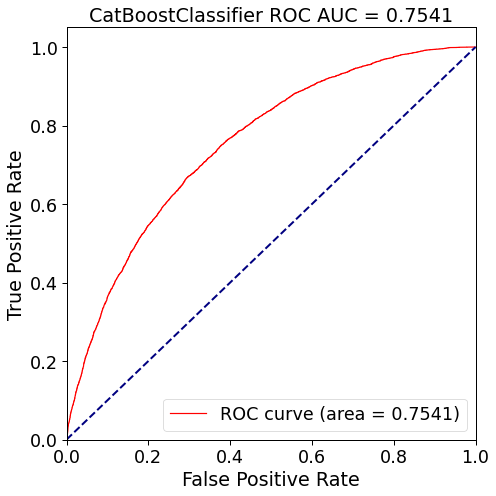

In [316]:
plt.figure(figsize=[7, 7])

fpr, tpr, thresholds = roc_curve(y_test, y_score_cb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
name = 'CatBoostClassifier'
num = float('{:.4f}'.format(roc_auc))
    
plt.title(F"{name} ROC AUC = {num}")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

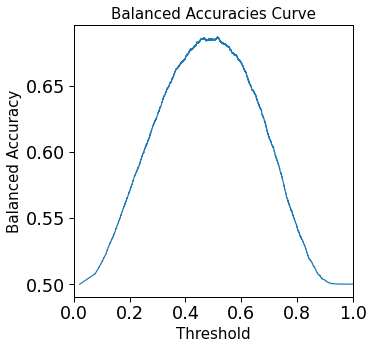

In [318]:
# График сбалансированной точности в зависимости от порога (Accuracy)
# Оптимальный порог - это порог, при котором наибольшая сбалансированная точность

plt.figure(figsize=[5, 5])

fprs, tprs, thresholds = roc_curve(y_test, y_score_cb)

sensitivities, specificities = tprs, 1 - fprs
balanced_accuracies = (sensitivities+specificities) / 2

plt.title("Balanced Accuracies Curve", fontsize=15)
plt.xlabel("Threshold", fontsize=15)
plt.ylabel("Balanced Accuracy", fontsize=15)
plt.xlim([0, 1])

plt.plot(thresholds, balanced_accuracies)
plt.show()

<AxesSubplot:>

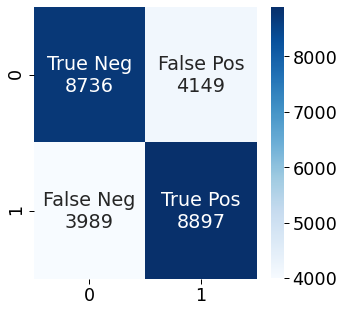

In [319]:
plt.figure(figsize=[5, 5])

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_cb).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_cb), annot=labels, fmt='', cmap='Blues')

In [320]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = roc_curve(y_test, y_score_cb)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

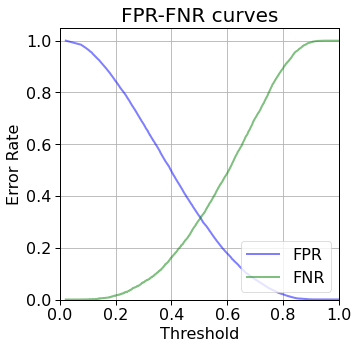

In [321]:
plt.figure(figsize=(5, 5))
lw = 2

plt.plot(thresholds, fprs, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [325]:
# Первые 10 главных признаков:
model = best_cb_ros

feat_names = X_test.columns
results = permutation_importance(model, X_test, y_test, scoring="roc_auc", random_state=RANDOM_SEED)
importance = results.importances_mean

feat_imp = pd.Series(importance, feat_names)
feat_imp.sort_values(ascending=False, inplace=True)

feat_imp.head(10)

score_bki          0.073990
region_rating      0.029170
home_address_2     0.020016
work_address_3     0.013604
sna_4              0.011243
bki_request_cnt    0.009592
decline_app_cnt    0.009209
education_2        0.008473
app_passed_days    0.005819
sex                0.005725
dtype: float64

In [ ]:
# cat_features = list(range(0, X.shape[1]))
# print(cat_features)

In [ ]:
# from catboost import *
# %pylab inline

# model = CatBoostClassifier(
#     iterations=350,
#     random_seed=63,
#     learning_rate=0.05,
#     depth = 4,
#     early_stopping_rounds = 10,
#     l2_leaf_reg = 7,
#     custom_loss=['AUC', 'Accuracy']
# )
# model.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_test, y_test),
#     verbose=False,
#     plot=True
# )

In [101]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

103083
25771
103083
25771


In [103]:
len(y_score_cb)

numpy.ndarray

In [102]:
y_score_cb

array([0.15022324, 0.0893969 , 0.40049105, ..., 0.35243513, 0.08896788,
       0.77436641])

In [108]:
res = pd.DataFrame(y_score_cb)
res.to_excel("Result_file.xlsx")